Objectiu o problema que es vol resoldre: Tractar de predir on es cometrà un delicte o número de delictes per un any. Classificar delictes per zona?
Predir en quina localització es produirá el crim(carrer,residencia) a través de el tipus de crim, si hi ha arrest, si es domestic etc.
Predir tipus de crim arrel de la localització del crim, arrest,domestic etc.

Llistat de funcions que farem servir per netejar el dataset

In [1]:
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
%matplotlib notebook
from matplotlib import pyplot as plt
import scipy.stats
import seaborn as sns
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split

# ML Libraries
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

# Evaluation Metrics
from sklearn import metrics
from yellowbrick.classifier import ClassificationReport

def datasetReplace(ds):
    ds = ds.replace("%", "", regex=True)
    ds = ds.replace(",", "", regex=True)
    return ds

def nullCounter(ds):
    print(ds.isnull().sum())
    print(ds.shape)
    
def printColumnTypes(ds):
    for line in ds.columns:
        print(line, type(ds[line][0]))
    print("-------------------------------------------------------")
    print(ds.shape)
    
# Visualitzarem només 3 decimals per mostra
pd.set_option('display.float_format', lambda x: '%.3f' % x)

pd.set_option('display.max_columns', None)
# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',', error_bad_lines=False)
    return dataset

def printColumnValues(ds):
    columns = ds.columns
    for col in columns:
        print(col ," values: ", ds[col].unique())
        print("---------------------------------------------------------------------------------------------")

In [2]:
# Carreguem 4 datasets, més endevant unirem tots i agafarem un nombre X de files per treballar
crimeC2001To2004 = load_dataset("data/Chicago_Crimes_2001_to_2004.csv")

crimeC2005To2007 = load_dataset("data/Chicago_Crimes_2005_to_2007.csv")

crimeC2008To2011 = load_dataset("data/Chicago_Crimes_2008_to_2011.csv")

crimeC2012To2017 = load_dataset("data/Chicago_Crimes_2012_to_2017.csv")

# Fusionem els 4 datasets en un sol

frames = [crimeC2001To2004, crimeC2005To2007, crimeC2008To2011, crimeC2012To2017]

crimeC = pd.concat(frames)

display(HTML(crimeC[50:70].to_html()))
nullCounter(crimeC)

print("Dimensionalitat de la BBDD:", crimeC.shape)

C:\Users\adria\AppData\Local\Temp\ipykernel_2796\1449035986.py:31: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dataset = pd.read_csv(path, header=0, delimiter=',', error_bad_lines=False)
b'Skipping line 1513591: expected 23 fields, saw 24\n'
C:\Users\adria\AppData\Local\Temp\ipykernel_2796\1449035986.py:31: DtypeWarning: Columns (17,20) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(path, header=0, delimiter=',', error_bad_lines=False)
C:\Users\adria\AppData\Local\Temp\ipykernel_2796\1449035986.py:31: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dataset = pd.read_csv(path, header=0, delimiter=',', error_bad_lines=False)
b'Skipping line 533719: expected 23 fields, saw 24\n'
C:\Users\adria\AppData\Local\Temp\ipykernel_2796\1449035986.py:31: FutureW

Unnamed: 0                   0
ID                           0
Case Number                  7
Date                         0
Block                        0
IUCR                         0
Primary Type                 0
Description                  0
Location Description      1990
Arrest                       0
Domestic                     0
Beat                         0
District                    91
Ward                    700224
Community Area          702091
FBI Code                     0
X Coordinate            105573
Y Coordinate            105573
Year                         0
Updated On                   0
Latitude                105573
Longitude               105574
Location                105574
dtype: int64
(7941282, 23)
Dimensionalitat de la BBDD: (7941282, 23)


Explicació dels atributs de la Base de dades:
- ID: Identificador únic per al registre.
- Case Number: Identificador únic per a un incident.
- Date: Data en la que va ocorrer el incident. A vegades pot set una estimació.
- Block: Direcció parcial(suposem per motius de privacitat,etc.) del lloc del incident.
- IUCR: Illinois Uniform Reporting Code. Está relacionat deirectament amb Primary Type i Description.
- Primary Type: Descripció principal del codi IUCR.
- Description: Descripció secundària del codi IUCR. Subcategoria de Primary Type.
- Location Description: Descripció de l'ubicació on va ocorrer l'incident.
- Arrest: Booleà que indica si va haver-hi un arrest o no.
- Domestic: Booleà que indica si l'incident està relacionat amb violència domèstica.
- Beat: Indica el beat(barrio?) on va ocorrer l'incident. Un beat és l'àrea geogràfica policial més petita.
- District: Indica el districte policial on va ocorrer l'incident.
- Ward: Districte del ajuntament on el incident va ocorrer.
- Community Area: Indica el àrea de comunitat on va ocorrer l'incident. Chicago té 77 d'aquestes àrees.
- FBI Code: Indica la classificació del delicte com es descriu en el FBI's National Incident-Based Reporting System (NIBRS).
- X Coordinate: La coordenada X de la ubicació on va ocorrer l'incident. Aquesta es mou de la ubicació real per a la redacció parcial, però cau al mateix Block.
- Y Coordinate: La coordenada Y de la ubicació on va ocorrer l'incident. Aquesta es mou de la ubicació real per a la redacció parcial, però cau al mateix Block.
- Year: Any en que va ocorrer l'incident.
- Updated On: Data i hora en que es va actualitzar el registre per últim cop.
- Latitude: La latitud on va ocorrer l'incident. Aquesta ubicació es mou de la real per a la redacció parcial, però cau en el mateix Block.
- Longitude: La longitud on va ocorrer l'incident.Aquesta ubicació es mou de la real per a la redacció parcial, però cau en el mateix Block.
- Location: Ubicació on va ocorrer l'incident en un format que permet la creació de mapes i altres operacions geogràfiques. Aquesta ubicació es mou de la real per a la redacció parcial, però cau en el mateix Block.

In [3]:
oldCrimeCShapeX = crimeC.shape[0]
print("Dimensionalitat X: ", oldCrimeCShapeX)

Dimensionalitat X:  7941282


Eliminem valors NaN directament, ja que la columna amb més nuls en té 700k que tampoc representa un gran problema tenint en compte el volum de dades que tenim de 7M de files. A més a més segurament acabaré agafant un subset de les dades ja que no tinc la capacitat de comput del superordinador del MareNostrum.

In [4]:
crimeC = crimeC.dropna()
crimeC = crimeC.drop(['Unnamed: 0'], axis=1)
nullCounter(crimeC)

ID                      0
Case Number             0
Date                    0
Block                   0
IUCR                    0
Primary Type            0
Description             0
Location Description    0
Arrest                  0
Domestic                0
Beat                    0
District                0
Ward                    0
Community Area          0
FBI Code                0
X Coordinate            0
Y Coordinate            0
Year                    0
Updated On              0
Latitude                0
Longitude               0
Location                0
dtype: int64
(7145213, 22)


In [5]:
newCrimeCShapeX = crimeC.shape[0]
print("Dimensionalitat X: ", newCrimeCShapeX)

print("Percentatge d'eliminats: ", (1-(newCrimeCShapeX/oldCrimeCShapeX))*100,"%")

Dimensionalitat X:  7145213
Percentatge d'eliminats:  10.024439378931515 %


Comprovo si n'hi han files duplicades

In [6]:
crimeC.drop_duplicates(subset=['ID', 'Case Number'], inplace=True)
crimeC.shape

(5478329, 22)

In [7]:
print("Percentatge d'eliminats sense duplicats: ", (1-(crimeC.shape[0]/oldCrimeCShapeX))*100,"%")

Percentatge d'eliminats sense duplicats:  31.01455155477415 %


In [8]:
crimeC.to_csv("data/Chicago_Crimes_2001_to_2017.csv", index=False)

Veure el tipus de dada per a cada columna

In [9]:
crimeC = load_dataset("data/Chicago_Crimes_2001_to_2017.csv")

C:\Users\adria\AppData\Local\Temp\ipykernel_2796\1449035986.py:31: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dataset = pd.read_csv(path, header=0, delimiter=',', error_bad_lines=False)


In [10]:
printColumnTypes(crimeC)

ID <class 'numpy.int64'>
Case Number <class 'str'>
Date <class 'str'>
Block <class 'str'>
IUCR <class 'str'>
Primary Type <class 'str'>
Description <class 'str'>
Location Description <class 'str'>
Arrest <class 'numpy.bool_'>
Domestic <class 'numpy.bool_'>
Beat <class 'numpy.int64'>
District <class 'numpy.float64'>
Ward <class 'numpy.float64'>
Community Area <class 'numpy.float64'>
FBI Code <class 'str'>
X Coordinate <class 'numpy.float64'>
Y Coordinate <class 'numpy.float64'>
Year <class 'numpy.float64'>
Updated On <class 'str'>
Latitude <class 'numpy.float64'>
Longitude <class 'numpy.float64'>
Location <class 'str'>
-------------------------------------------------------
(5478329, 22)


El següent pas a fer serà passar els atributs categòrics o no numèrics a valors numèrics. També s'eliminaràn les columnes que no serveixen per aconseguir l'objectiu.

In [11]:
printColumnValues(crimeC)

ID  values:  [ 4676906  4677901  4791194 ... 10508681 10508690 10508692]
---------------------------------------------------------------------------------------------
Case Number  values:  ['HM278933' 'HM275615' 'HM403711' ... 'HZ250479' 'HZ250370' 'HZ250517']
---------------------------------------------------------------------------------------------
Date  values:  ['03/01/2003 12:00:00 AM' '05/01/2003 01:00:00 AM'
 '01/01/2001 11:00:00 AM' ... '05/03/2016 11:28:00 PM'
 '05/03/2016 11:33:00 PM' '05/03/2016 09:07:00 PM']
---------------------------------------------------------------------------------------------
Block  values:  ['004XX W 42ND PL' '111XX S NORMAL AVE' '114XX S ST LAWRENCE AVE' ...
 '030XX W Carroll Ave' '061XX S Oak Park Ave' '000XX W 79TH ST']
---------------------------------------------------------------------------------------------
IUCR  values:  ['2825' '0841' '0266' '5007' '0840' '1753' '1754' '0910' '0810' '1563'
 '1150' '0842' '1130' '1752' '0281' '1562' '500

Location Description  values:  ['RESIDENCE' 'RESIDENCE PORCH/HALLWAY' 'APARTMENT' 'OTHER' 'GAS STATION'
 'COMMERCIAL / BUSINESS OFFICE' 'STREET' 'BANK' 'APPLIANCE STORE'
 'PARKING LOT/GARAGE(NON.RESID.)' 'CHURCH/SYNAGOGUE/PLACE OF WORSHIP'
 'DAY CARE CENTER' 'HOSPITAL BUILDING/GROUNDS' 'HOTEL/MOTEL'
 'SCHOOL, PRIVATE, GROUNDS' 'VEHICLE NON-COMMERCIAL' 'ALLEY'
 'SMALL RETAIL STORE' 'DEPARTMENT STORE' 'RESTAURANT'
 'MEDICAL/DENTAL OFFICE' 'CHA STAIRWELL' 'AUTO' 'RETAIL STORE' 'TAVERN'
 'GAS STATION DRIVE/PROP.' 'HALLWAY' 'TRUCK' 'GANGWAY' 'PARKING LOT'
 'FACTORY/MANUFACTURING BUILDING' 'HOUSE' 'COACH HOUSE' 'PORCH' 'CLUB'
 'SCHOOL, PUBLIC, BUILDING' 'BASEMENT' 'VACANT LOT' 'YARD' 'SIDEWALK'
 'AIRPORT BUILDING NON-TERMINAL - SECURE AREA' 'CHA APARTMENT' 'CAR WASH'
 'LOADING DOCK' 'CHA ELEVATOR' 'VESTIBULE' 'CHA HALLWAY'
 'GOVERNMENT BUILDING/PROPERTY'
 'AIRPORT TERMINAL UPPER LEVEL - SECURE AREA' 'GARAGE'
 'ABANDONED BUILDING' 'PARK PROPERTY' 'RAILROAD PROPERTY' 'CHA PLAY LOT'
 'CHA GROUN

Passem la data a un format que comprengui python

In [12]:
crimeC['Date'] = pd.to_datetime(crimeC['Date'], format='%m/%d/%Y %I:%M:%S %p')

Esborrem les columnes que a priori no ens serviran de gaire

In [13]:
crimeC = crimeC.drop(['Case Number', 'IUCR', 'Updated On', 'FBI Code', 'Location'], axis=1)

Guardem els canvis en un nou dataset per no haver d'estar executant tot el codi cada cop

In [14]:
crimeC.to_csv("data/Chicago_Crimes_2001_to_2017_parsed.csv", index=False)

In [2]:
crimeC = load_dataset("data/Chicago_Crimes_2001_to_2017_parsed.csv")

C:\Users\adria\AppData\Local\Temp\ipykernel_15296\9023838.py:42: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dataset = pd.read_csv(path, header=0, delimiter=',', error_bad_lines=False)


In [3]:
crimeC['Date'] = crimeC['Date'].astype('datetime64[ns]')

In [17]:
printColumnTypes(crimeC)

ID <class 'numpy.int64'>
Date <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Block <class 'str'>
Primary Type <class 'str'>
Description <class 'str'>
Location Description <class 'str'>
Arrest <class 'numpy.bool_'>
Domestic <class 'numpy.bool_'>
Beat <class 'numpy.int64'>
District <class 'numpy.float64'>
Ward <class 'numpy.float64'>
Community Area <class 'numpy.float64'>
X Coordinate <class 'numpy.float64'>
Y Coordinate <class 'numpy.float64'>
Year <class 'numpy.float64'>
Latitude <class 'numpy.float64'>
Longitude <class 'numpy.float64'>
-------------------------------------------------------
(5478329, 17)


In [18]:
print(len(set(crimeC['Beat'].values)))
print(len(crimeC['Beat'].values))

303
5478329


In [19]:
print(len(set(crimeC['Block'].values)))
print(len(crimeC['Block'].values))

34221
5478329


In [20]:
print(len(set(crimeC['District'].values)))
print(len(crimeC['District'].values))

26
5478329


<IPython.core.display.Javascript object>


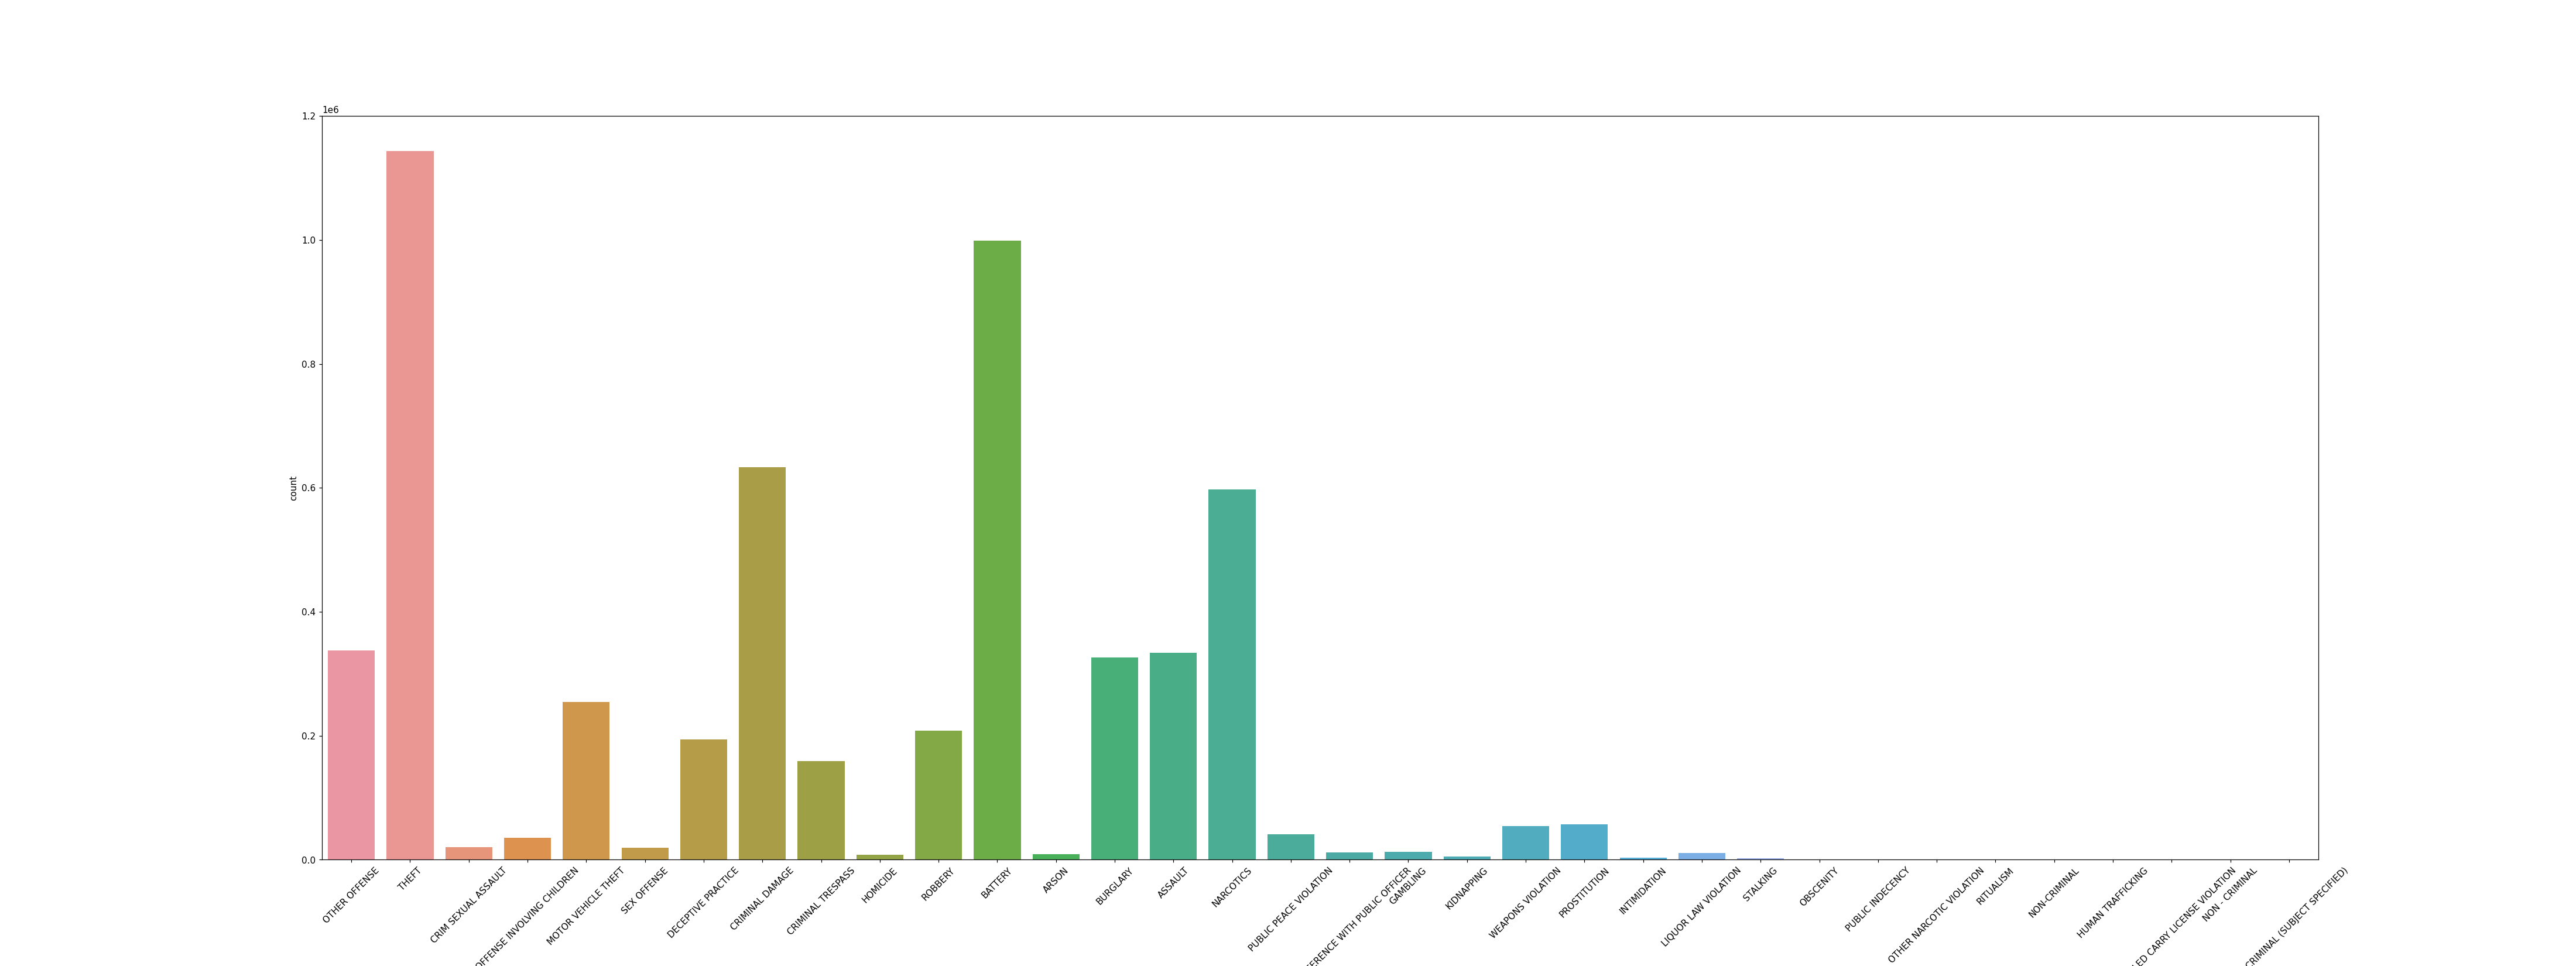

In [21]:
classes = set(crimeC['Primary Type'].values)
df = pd.DataFrame(columns=['Crime', 'Ocurrence'])

for index in classes:
    #print("Repeticiones ", index, ": ", list(crimeC['Primary Type'].values).count(index))
    aux = pd.DataFrame([[index, list(crimeC['Primary Type'].values).count(index)]], columns=['Crime', 'Ocurrence'])
    df = pd.concat([df, aux], axis=0)

#sns.histplot(data=df, x=df['Crime'])
#df = crimeC['Primary Type']
#print(df)
plt.figure(figsize=(40,15))
chart = sns.countplot(data=crimeC, x='Primary Type')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart.get_figure().savefig("images/crimesCountplot.png")

<IPython.core.display.Javascript object>


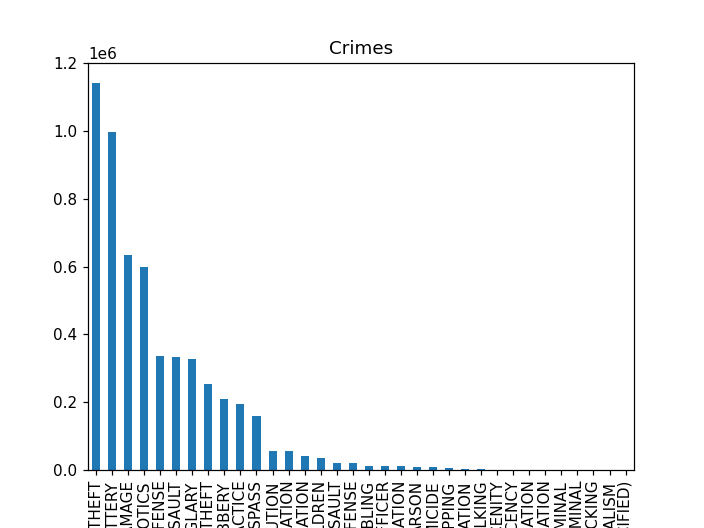

In [22]:
plt.figure()
crimeC['Primary Type'].value_counts().plot.bar()
plt.title("Crimes")
plt.show()

In [23]:
df

Crime Ocurrence
0                           BURGLARY    326234
0                     NON - CRIMINAL        38
0                    CRIMINAL DAMAGE    633246
0                  WEAPONS VIOLATION     54516
0             PUBLIC PEACE VIOLATION     41041
0                       INTIMIDATION      3171
0                       PROSTITUTION     56985
0                           HOMICIDE      7812
0                       NON-CRIMINAL        80
0                 DECEPTIVE PRACTICE    194091
0                        SEX OFFENSE     18975
0                          RITUALISM        13
0                  CRIMINAL TRESPASS    159349
0   INTERFERENCE WITH PUBLIC OFFICER     12250
0                         KIDNAPPING      5022
0                           STALKING      2626
0                            ASSAULT    334045
0                            BATTERY    998674
0                              ARSON      8863
0                CRIM SEXUAL ASSAULT     20166
0                   PUBLIC INDECENCY       124
0         OFFENSE INVOLVING CHILDREN     35484
0                          NARCOTICS    597701
0           OTHER NARCOTIC VIOLATION       101
0               LIQUOR LAW VIOLATION     11291
0   NON-CRIMINAL (SUBJECT SPECIFIED)         4
0                           GAMBLING     12669
0                          OBSCENITY       363
0                      OTHER OFFENSE    337754
0                MOTOR VEHICLE THEFT    254388
0                  HUMAN TRAFFICKING        20
0                              THEFT   1143153
0  CONCEALED CARRY LICENSE VIOLATION        84
0                            ROBBERY    207996

A partir d'aquí eliminarem els tipus de crim que no passin dels 100.000 casos, per tal de centrar-nos en els que més es repeteixen

In [24]:
types = df['Crime'].values
ocurrence = df['Ocurrence'].values
crimes = zip(types,ocurrence)

In [25]:
THRESHOLD = 100000
for crime, repetitions in crimes:
    if(repetitions < THRESHOLD):
        crimeC = crimeC.drop(crimeC.index[crimeC['Primary Type'] == crime])

In [26]:
crimeC.shape

(5186631, 17)

In [27]:
crimeC['Primary Type'].unique()

array(['OTHER OFFENSE', 'THEFT', 'MOTOR VEHICLE THEFT',
       'DECEPTIVE PRACTICE', 'CRIMINAL DAMAGE', 'CRIMINAL TRESPASS',
       'ROBBERY', 'BATTERY', 'BURGLARY', 'ASSAULT', 'NARCOTICS'],
      dtype=object)

<IPython.core.display.Javascript object>


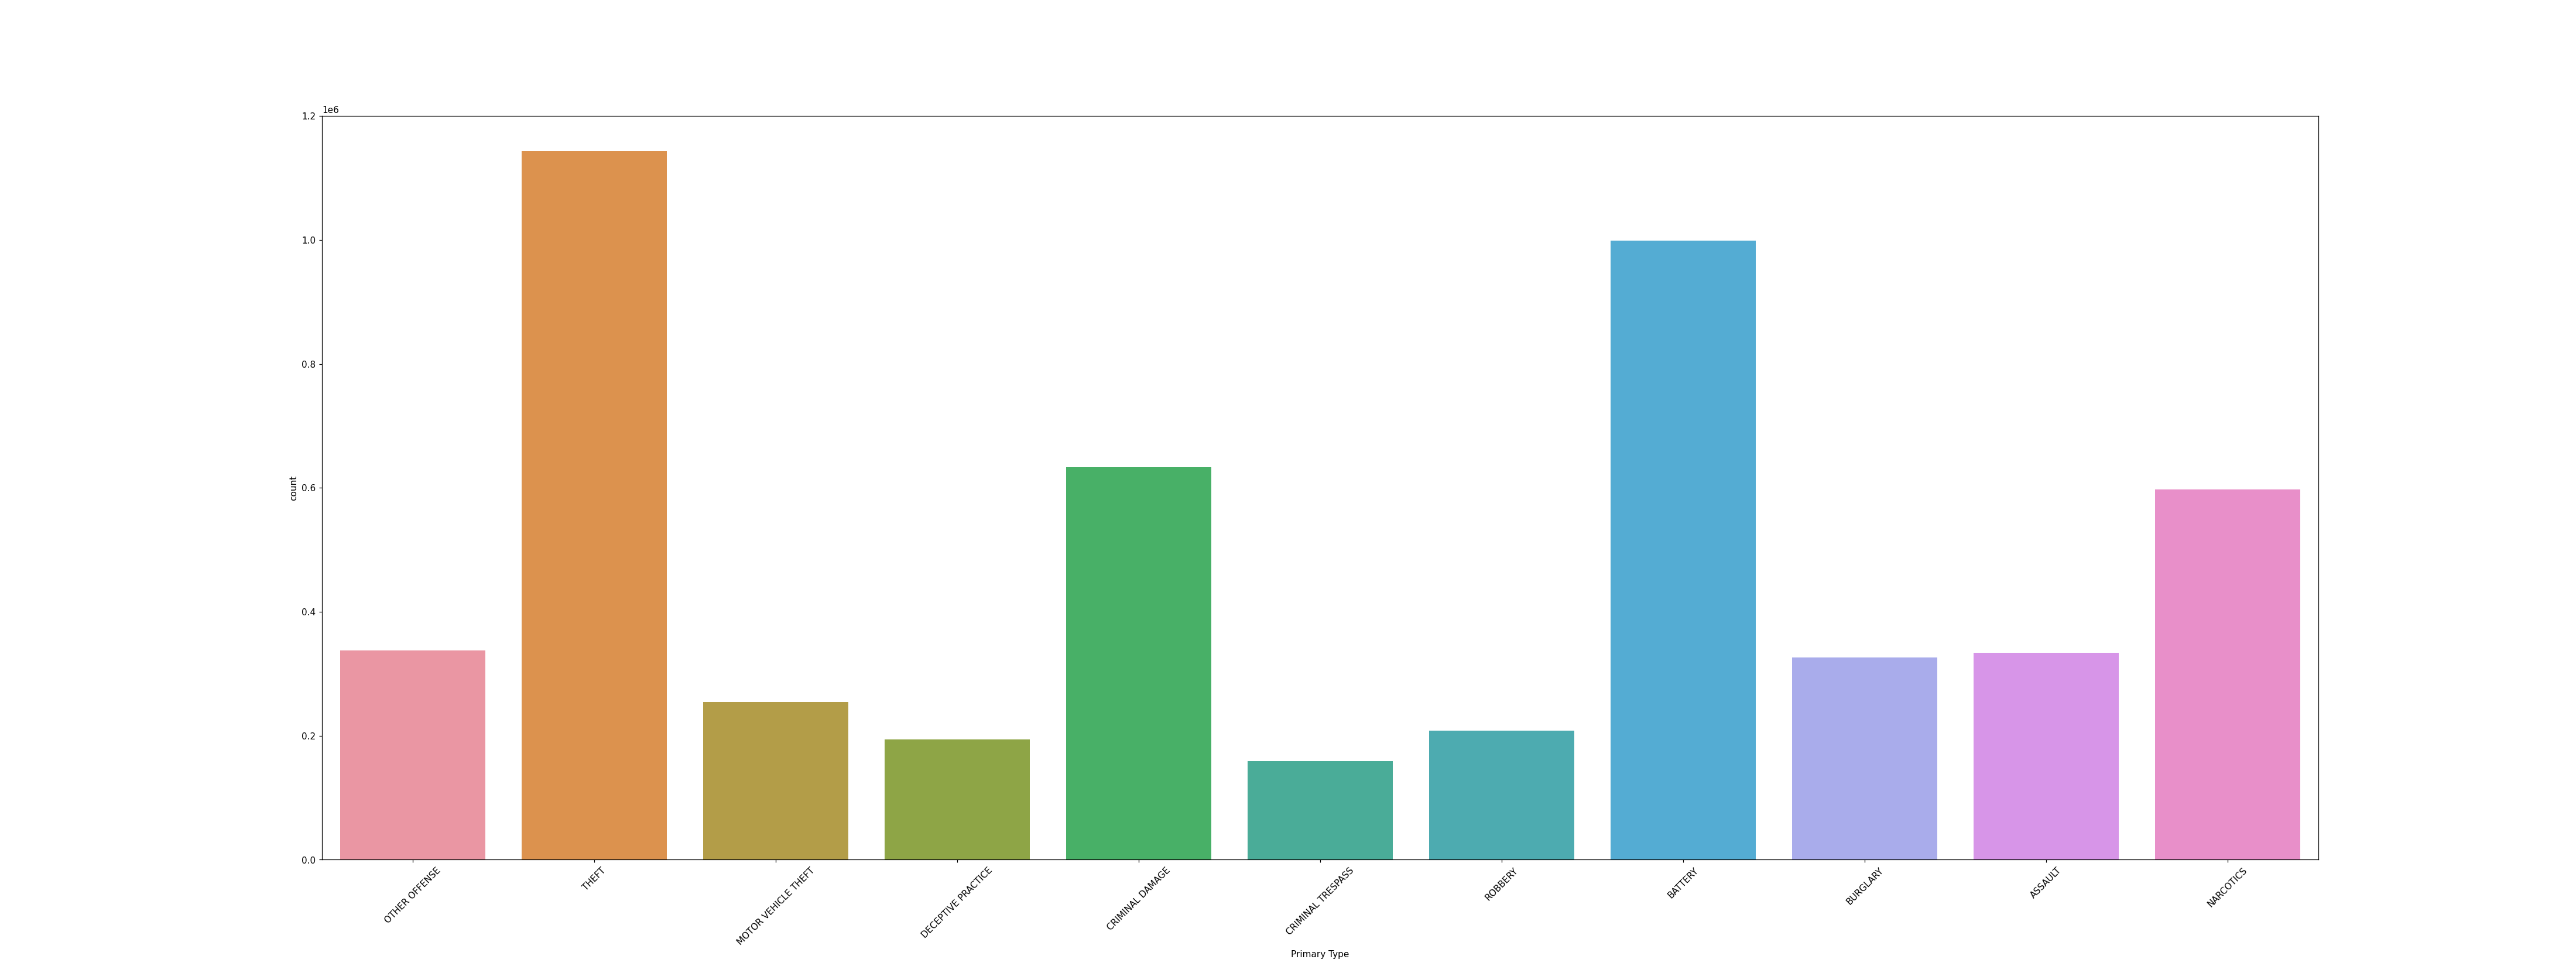

In [28]:
classes = set(crimeC['Primary Type'].values)
df = pd.DataFrame(columns=['Crime', 'Ocurrence'])

for index in classes:
    #print("Repeticiones ", index, ": ", list(crimeC['Primary Type'].values).count(index))
    aux = pd.DataFrame([[index, list(crimeC['Primary Type'].values).count(index)]], columns=['Crime', 'Ocurrence'])
    df = pd.concat([df, aux], axis=0)

#sns.histplot(data=df, x=df['Crime'])
#df = crimeC['Primary Type']
#print(df)
plt.figure(figsize=(40,15))
chart = sns.countplot(data=crimeC, x='Primary Type')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart.get_figure().savefig("images/crimesCountplot_v2.png")

Guardem el dataset amb els canvis

In [29]:
crimeC.to_csv("data/Chicago_Crimes_2001_to_2017_parsed_v2.csv", index=False)

In [101]:
crimeC = load_dataset("data/Chicago_Crimes_2001_to_2017_parsed_v2.csv")

In [102]:
crimeC['Date'] = crimeC['Date'].astype('datetime64[ns]')

Mostrem la quantitat de crims d'un mateix tipus per any.

In [32]:
##Update crime tags
crimes = crimeC['Primary Type'].unique()

years = crimeC['Year'].unique()
years.sort()
result = pd.DataFrame(columns=['Year', 'Crime', 'Ocurrence'])

for year in years:
    for crime in crimes:
        tuple1 = np.where((crimeC['Primary Type'] == crime) & (crimeC['Year'] == year))
        aux = pd.DataFrame([[year, crime, len(tuple1[0])]], columns=['Year', 'Crime', 'Ocurrence'])
        result = pd.concat([result, aux], axis=0)

In [33]:
result.reset_index(drop=True, inplace=True)
result[0:23]

Year                Crime Ocurrence
0  2001.000        OTHER OFFENSE       181
1  2001.000                THEFT      1214
2  2001.000  MOTOR VEHICLE THEFT       639
3  2001.000   DECEPTIVE PRACTICE       394
4  2001.000      CRIMINAL DAMAGE        76
5  2001.000    CRIMINAL TRESPASS        11
6  2001.000              ROBBERY        36
7  2001.000              BATTERY       147
8  2001.000             BURGLARY        38
9  2001.000              ASSAULT        46
10 2001.000            NARCOTICS       120
11 2002.000        OTHER OFFENSE     22150
12 2002.000                THEFT     71663
13 2002.000  MOTOR VEHICLE THEFT     17493
14 2002.000   DECEPTIVE PRACTICE      9983
15 2002.000      CRIMINAL DAMAGE     39619
16 2002.000    CRIMINAL TRESPASS      9497
17 2002.000              ROBBERY     13152
18 2002.000              BATTERY     67919
19 2002.000             BURGLARY     18921
20 2002.000              ASSAULT     22757
21 2002.000            NARCOTICS     33977
22 2003.000        OTHER OFFENSE     30815

Com es pot veure l'any 2001 té molt pocs casos en comparació amb la resta, per tant, decideixo borrar les files per aquest any.

In [103]:
crimeC = crimeC.drop(crimeC.index[crimeC['Year'] == 2001])

In [35]:
##Update crime tags
crimes = crimeC['Primary Type'].unique()

years = crimeC['Year'].unique()
years.sort()
result = pd.DataFrame(columns=['Year', 'Crime', 'Ocurrence'])

for year in years:
    for crime in crimes:
        tuple1 = np.where((crimeC['Primary Type'] == crime) & (crimeC['Year'] == year))
        aux = pd.DataFrame([[year, crime, len(tuple1[0])]], columns=['Year', 'Crime', 'Ocurrence'])
        result = pd.concat([result, aux], axis=0)

In [36]:
result.reset_index(drop=True, inplace=True)
result[150:180]

Year                Crime Ocurrence
150 2015.000      CRIMINAL DAMAGE     28526
151 2015.000              ASSAULT     16945
152 2015.000            NARCOTICS     22839
153 2015.000    CRIMINAL TRESPASS      6382
154 2016.000        OTHER OFFENSE     15910
155 2016.000                THEFT     58328
156 2016.000  MOTOR VEHICLE THEFT     11005
157 2016.000   DECEPTIVE PRACTICE     13511
158 2016.000             BURGLARY     13612
159 2016.000              ROBBERY     11611
160 2016.000              BATTERY     48686
161 2016.000      CRIMINAL DAMAGE     30189
162 2016.000              ASSAULT     18080
163 2016.000            NARCOTICS     10664
164 2016.000    CRIMINAL TRESPASS      6209

Gràfics per número de crims d'un sol tipus per any.

<IPython.core.display.Javascript object>


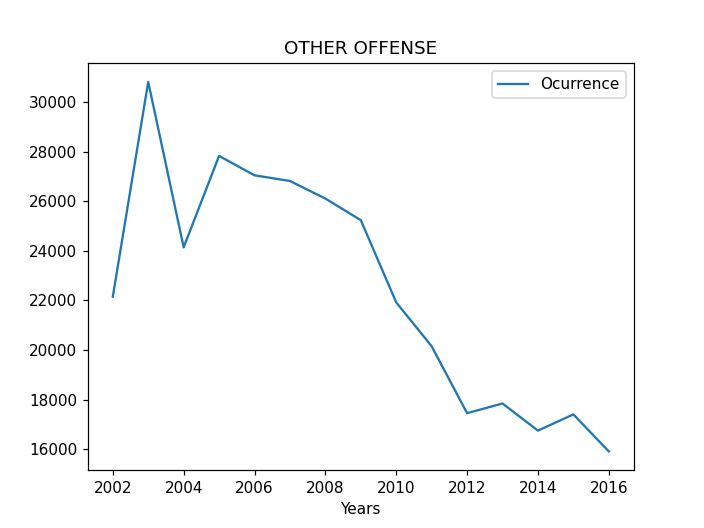

<IPython.core.display.Javascript object>


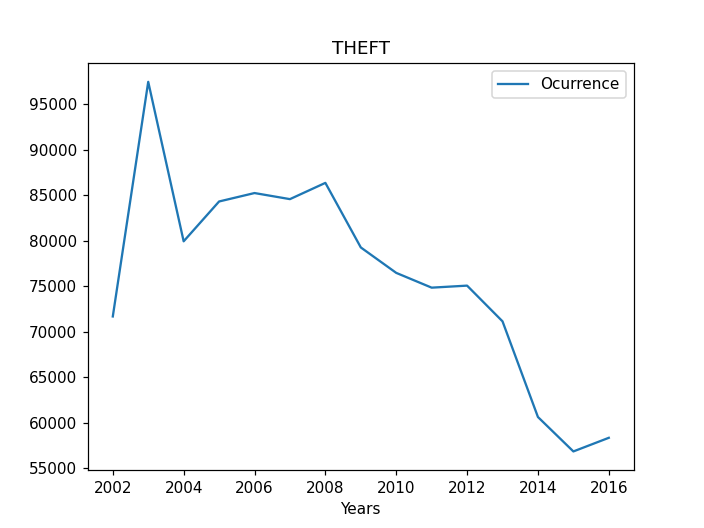

<IPython.core.display.Javascript object>


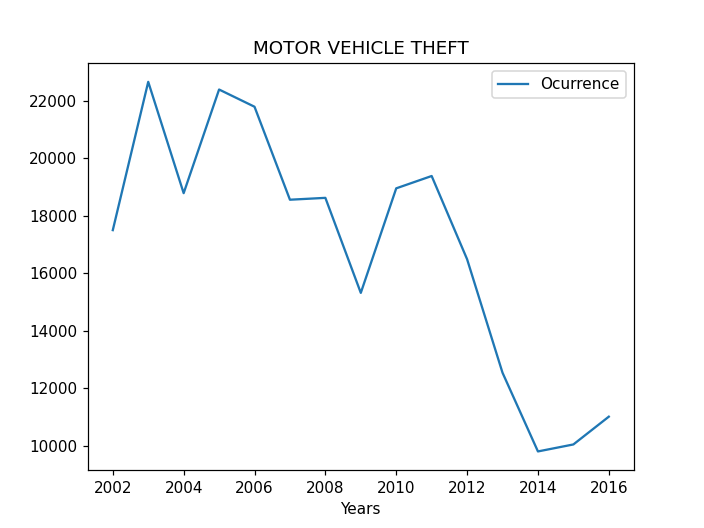

<IPython.core.display.Javascript object>


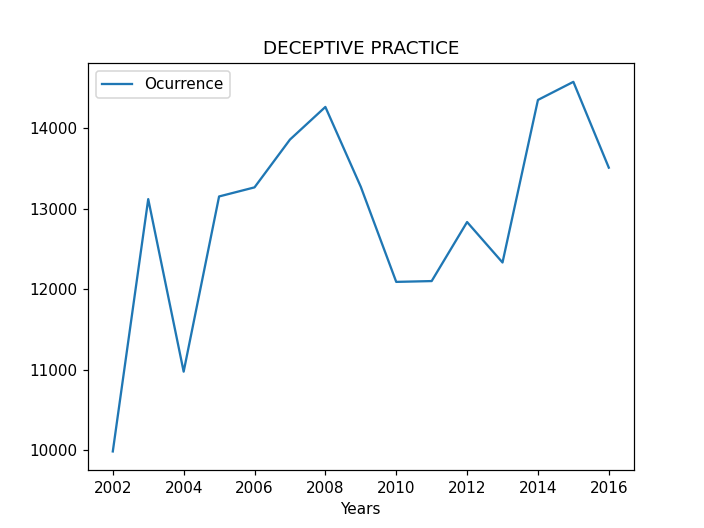

<IPython.core.display.Javascript object>


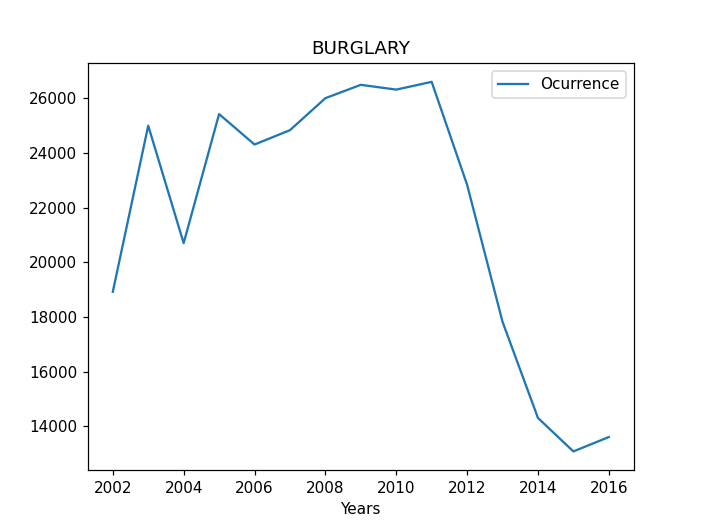

<IPython.core.display.Javascript object>


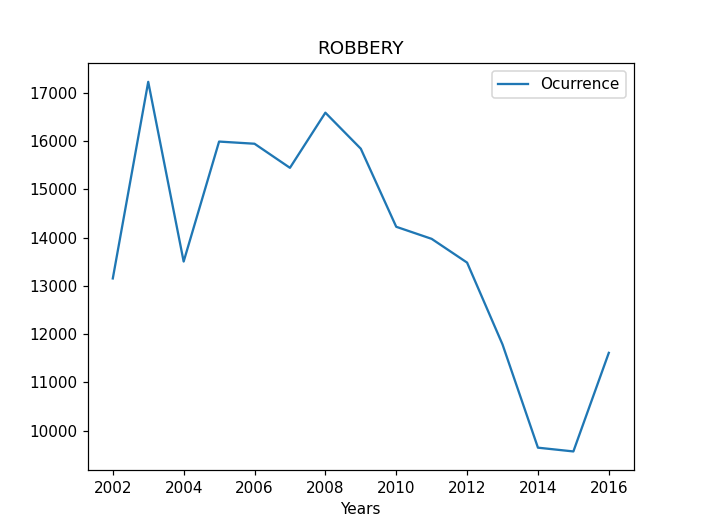

<IPython.core.display.Javascript object>


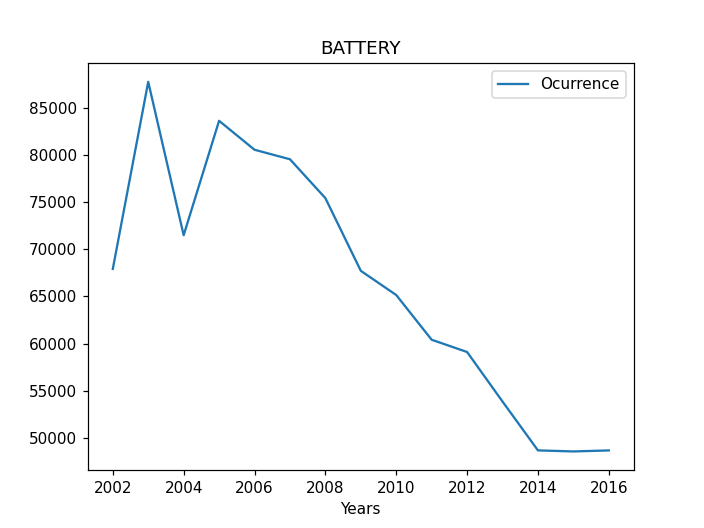

<IPython.core.display.Javascript object>


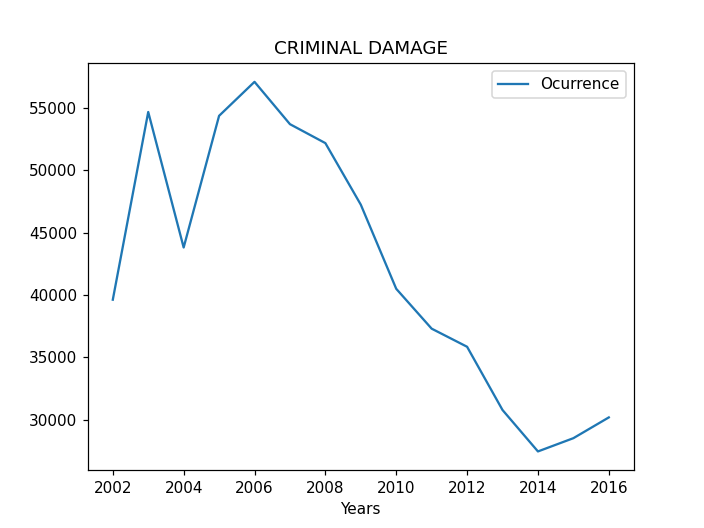

<IPython.core.display.Javascript object>


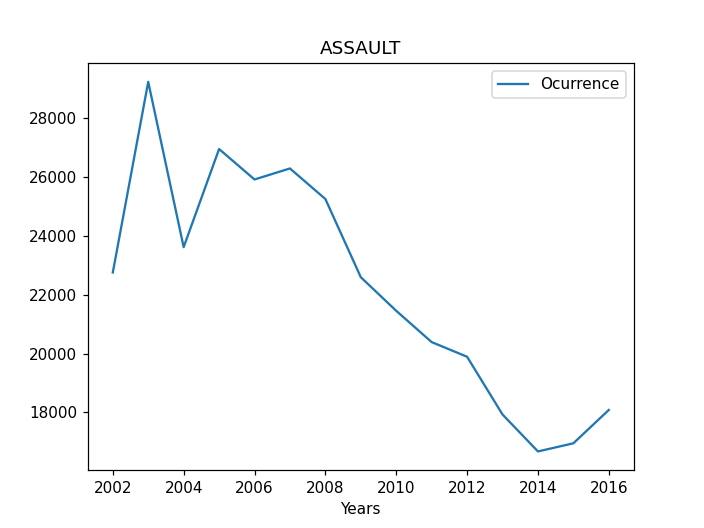

<IPython.core.display.Javascript object>


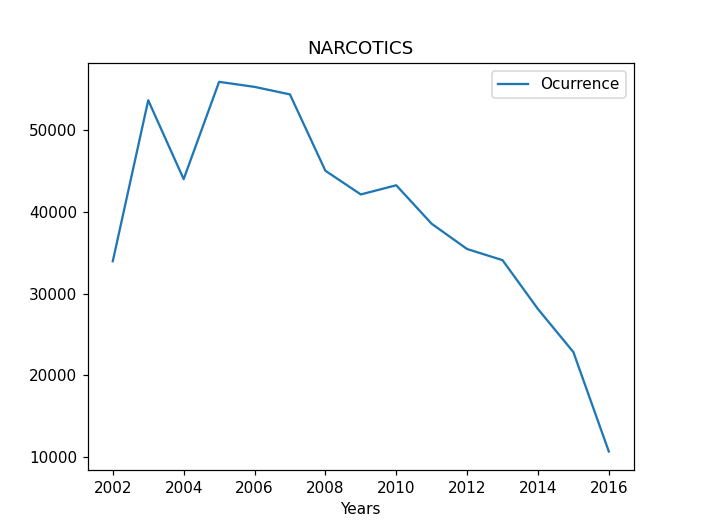

<IPython.core.display.Javascript object>


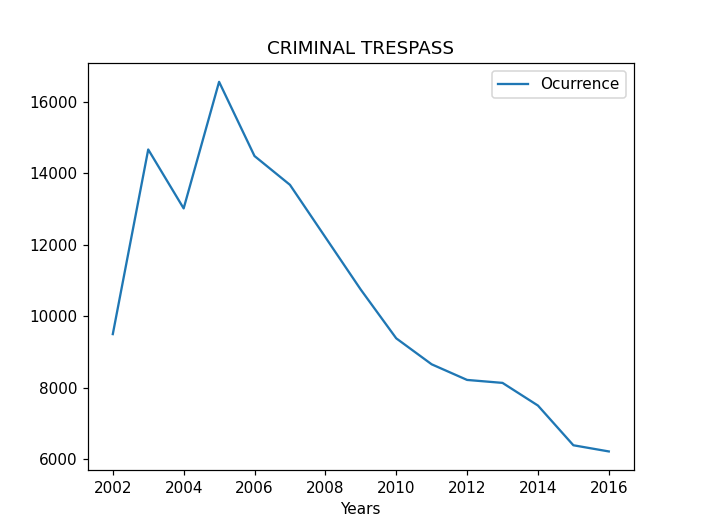

In [37]:
years = list(result['Year'].unique())
crimes = result['Crime'].unique()

for crime in crimes:
    indexes = np.where(result['Crime'] == crime)
    for index in indexes:
        ocurrences = list(result['Ocurrence'][index])
        
    aux = list(zip(years, ocurrences))
    df = pd.DataFrame(aux, columns=['Years', 'Ocurrence'])
    
    
    plt = df.plot(x = 'Years', y = 'Ocurrence', title=crime)

In [38]:
crimeC.to_csv("data/Chicago_Crimes_2001_to_2017_parsed_v3.csv", index=False)

In [15]:
crimeC = load_dataset("data/Chicago_Crimes_2001_to_2017_parsed_v3.csv")

C:\Users\adria\AppData\Local\Temp\ipykernel_15296\9023838.py:42: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dataset = pd.read_csv(path, header=0, delimiter=',', error_bad_lines=False)


In [16]:
crimeC['Date'] = crimeC['Date'].astype('datetime64[ns]')

In [41]:
crimeC.describe()

ID        Beat    District        Ward  Community Area  \
count  5183729.000 5183729.000 5183729.000 5183729.000     5183729.000   
mean   6318955.222    1193.083      11.304      22.655          37.617   
std    2550626.694     703.728       6.946      13.854          21.574   
min    1918036.000     111.000       1.000       1.000           0.000   
25%    4038735.000     622.000       6.000      10.000          23.000   
50%    6352803.000    1111.000      10.000      22.000          32.000   
75%    8505888.000    1731.000      17.000      34.000          58.000   
max   10823344.000    2535.000      31.000      50.000          77.000   

       X Coordinate  Y Coordinate        Year    Latitude   Longitude  
count   5183729.000   5183729.000 5183729.000 5183729.000 5183729.000  
mean    1164509.026   1885583.889    2008.333      41.842     -87.672  
std       17503.721     33195.419       4.108       0.091       0.063  
min           0.000         0.000    2002.000      36.619     -91.687  
25%     1152933.000   1858905.000    2005.000      41.768     -87.714  
50%     1165994.000   1890281.000    2008.000      41.855     -87.666  
75%     1176352.000   1909397.000    2012.000      41.907     -87.628  
max     1205119.000   1951573.000    2016.000      42.023     -87.525

In [42]:
result

Year                Crime Ocurrence
0   2002.000        OTHER OFFENSE     22150
1   2002.000                THEFT     71663
2   2002.000  MOTOR VEHICLE THEFT     17493
3   2002.000   DECEPTIVE PRACTICE      9983
4   2002.000             BURGLARY     18921
..       ...                  ...       ...
160 2016.000              BATTERY     48686
161 2016.000      CRIMINAL DAMAGE     30189
162 2016.000              ASSAULT     18080
163 2016.000            NARCOTICS     10664
164 2016.000    CRIMINAL TRESPASS      6209

[165 rows x 3 columns]

Preparem un nou dataset temporal per mostrar el total de crims per any, per veure una evolució de la criminalitat a través dels anys

In [43]:
years = list(result['Year'].unique())
total = [0]*len(years)
dataList = list(zip(years,total))
totalCrimesYear = pd.DataFrame(dataList,columns=['Year', 'Total'])

totalCrimesYear

Year  Total
0  2002.000      0
1  2003.000      0
2  2004.000      0
3  2005.000      0
4  2006.000      0
5  2007.000      0
6  2008.000      0
7  2009.000      0
8  2010.000      0
9  2011.000      0
10 2012.000      0
11 2013.000      0
12 2014.000      0
13 2015.000      0
14 2016.000      0

In [44]:
years = result['Year']
ocurrences = result['Ocurrence']

for i in range(len(result['Year'])):
    for j in range(len(totalCrimesYear['Year'])):
        if(result['Year'][i] == totalCrimesYear['Year'][j]):
            totalCrimesYear['Total'][j] += result['Ocurrence'][i]

C:\Users\adria\AppData\Local\Temp\ipykernel_2796\699893407.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalCrimesYear['Total'][j] += result['Ocurrence'][i]


Comprovem que tenim un resultat correcte

In [45]:
total = totalCrimesYear['Total'].sum()
total

5183729

In [46]:
totalCrimesYear

Year   Total
0  2002.000  327131
1  2003.000  446251
2  2004.000  363975
3  2005.000  426501
4  2006.000  420925
5  2007.000  411660
6  2008.000  398025
7  2009.000  365832
8  2010.000  349694
9  2011.000  332332
10 2012.000  316669
11 2013.000  288254
12 2014.000  253897
13 2015.000  244778
14 2016.000  237805

Fem el plot de total de crims per any.

<IPython.core.display.Javascript object>


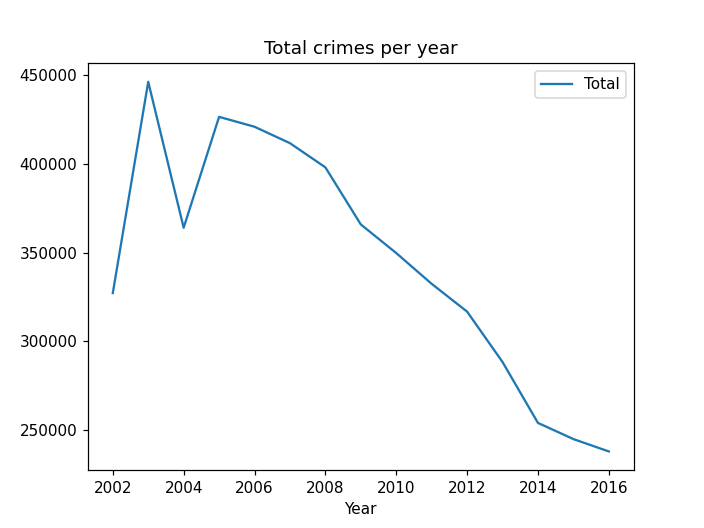

In [47]:
plt = totalCrimesYear.plot(x = 'Year', y = 'Total', title='Total crimes per year')

<IPython.core.display.Javascript object>


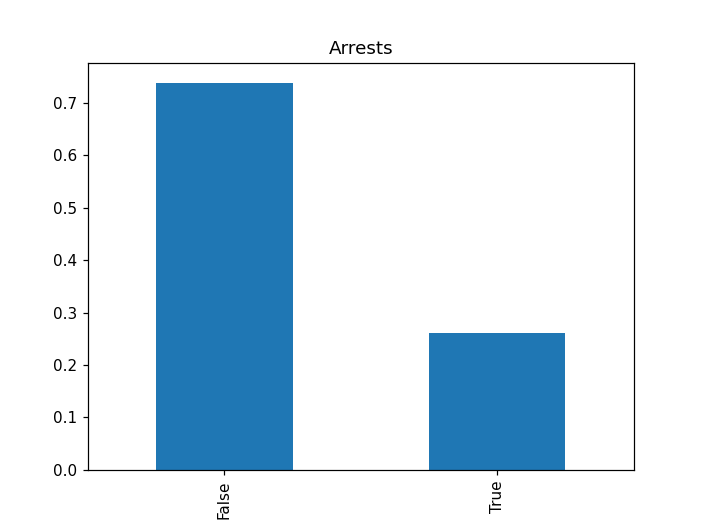

In [50]:
plt.figure()
crimeC['Arrest'].value_counts(normalize=True).plot.bar()
plt.title("Arrests")
plt.show()

<IPython.core.display.Javascript object>


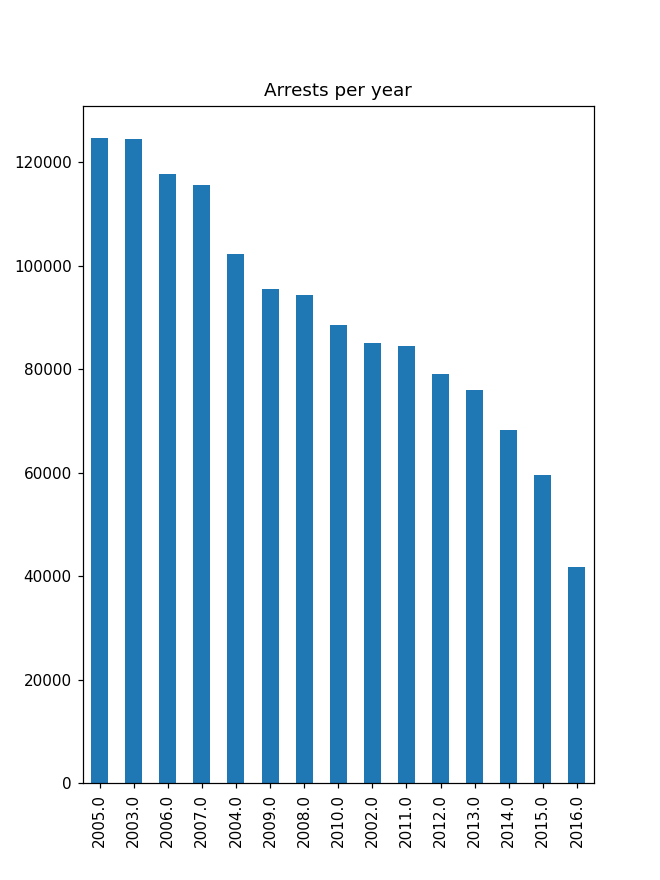

In [51]:
plt.figure(figsize=(6,8))
crimeC[crimeC.Arrest == True]['Year'].value_counts().plot.bar()
plt.title("Arrests per year")
plt.show()

Passem les variables categòriques a numèriques.

In [17]:
crimeC = crimeC.drop(['Block', 'Description'], axis=1)

In [53]:
printColumnTypes(crimeC)

ID <class 'numpy.int64'>
Date <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Primary Type <class 'str'>
Location Description <class 'str'>
Arrest <class 'numpy.bool_'>
Domestic <class 'numpy.bool_'>
Beat <class 'numpy.int64'>
District <class 'numpy.float64'>
Ward <class 'numpy.float64'>
Community Area <class 'numpy.float64'>
X Coordinate <class 'numpy.float64'>
Y Coordinate <class 'numpy.float64'>
Year <class 'numpy.float64'>
Latitude <class 'numpy.float64'>
Longitude <class 'numpy.float64'>
-------------------------------------------------------
(5183729, 15)


In [54]:
primaryTypes = list(crimeC['Primary Type'].unique())
lenPrimaryTypes = list(range(len(crimeC['Primary Type'].unique())))
print("Primary types:", primaryTypes)
print("Range primary types: ",lenPrimaryTypes)
print("----------------------------------------------------------------------------------------------------------------")
locationDescription = list(crimeC['Location Description'].unique())
lenLocationDescription = list(range(len(crimeC['Location Description'].unique())))
print("Location Description:", locationDescription)
print("Range location description:", lenLocationDescription)

Primary types: ['OTHER OFFENSE', 'THEFT', 'MOTOR VEHICLE THEFT', 'DECEPTIVE PRACTICE', 'BURGLARY', 'ROBBERY', 'BATTERY', 'CRIMINAL DAMAGE', 'ASSAULT', 'NARCOTICS', 'CRIMINAL TRESPASS']
Range primary types:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
----------------------------------------------------------------------------------------------------------------
Location Description: ['RESIDENCE', 'RESIDENCE PORCH/HALLWAY', 'APARTMENT', 'GAS STATION', 'COMMERCIAL / BUSINESS OFFICE', 'OTHER', 'STREET', 'BANK', 'APPLIANCE STORE', 'PARKING LOT/GARAGE(NON.RESID.)', 'CHURCH/SYNAGOGUE/PLACE OF WORSHIP', 'HOSPITAL BUILDING/GROUNDS', 'ALLEY', 'SMALL RETAIL STORE', 'HOTEL/MOTEL', 'SCHOOL, PRIVATE, BUILDING', 'CHA HALLWAY/STAIRWELL/ELEVATOR', 'SCHOOL, PUBLIC, BUILDING', 'DEPARTMENT STORE', 'OTHER RAILROAD PROP / TRAIN DEPOT', 'RESTAURANT', 'CTA TRAIN', 'GROCERY FOOD STORE', 'VACANT LOT/LAND', 'SIDEWALK', 'BAR OR TAVERN', 'RESIDENCE-GARAGE', 'DRIVEWAY - RESIDENTIAL', 'AIRPORT/AIRCRAFT', 'TAVERN/LIQUOR STOR

Gràfic amb el número de crims per localització, és a dir, on es produeix el crim.

<IPython.core.display.Javascript object>


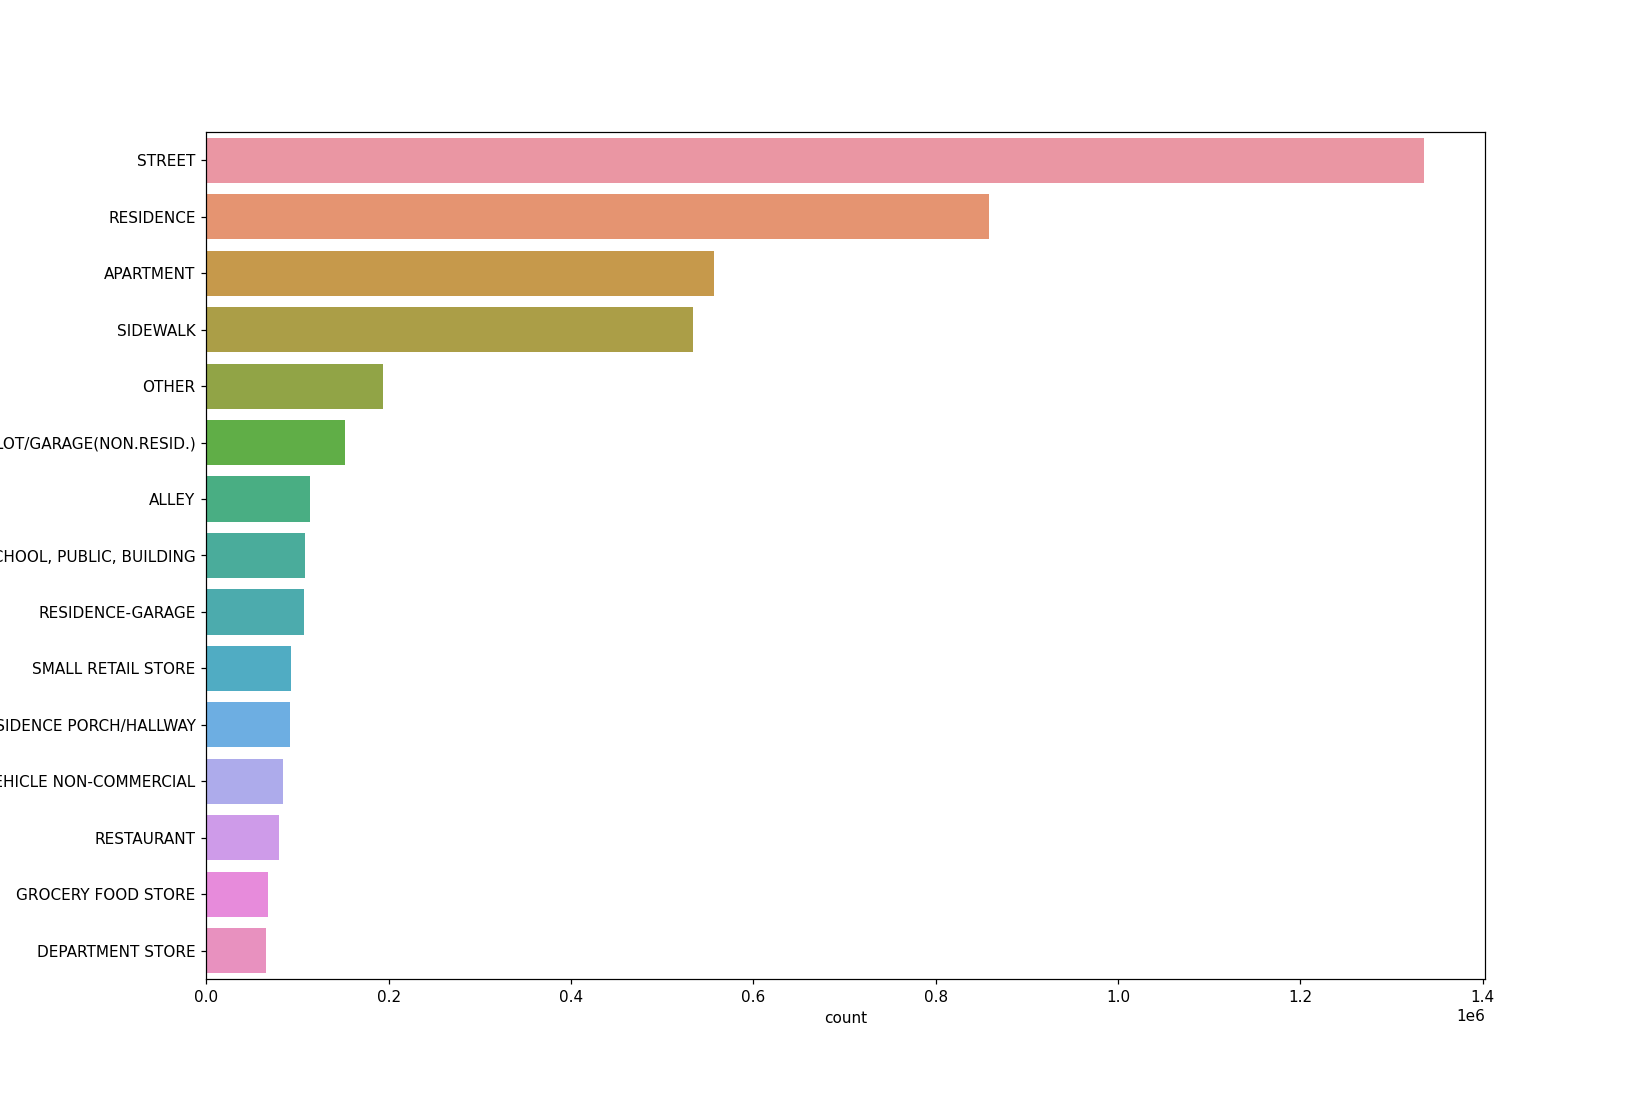

<AxesSubplot: xlabel='count', ylabel='Location Description'>

In [55]:
plt.figure(figsize = (15, 10))
sns.countplot(y= 'Location Description', data = crimeC, order = crimeC['Location Description'].value_counts().iloc[:15].index)

<IPython.core.display.Javascript object>


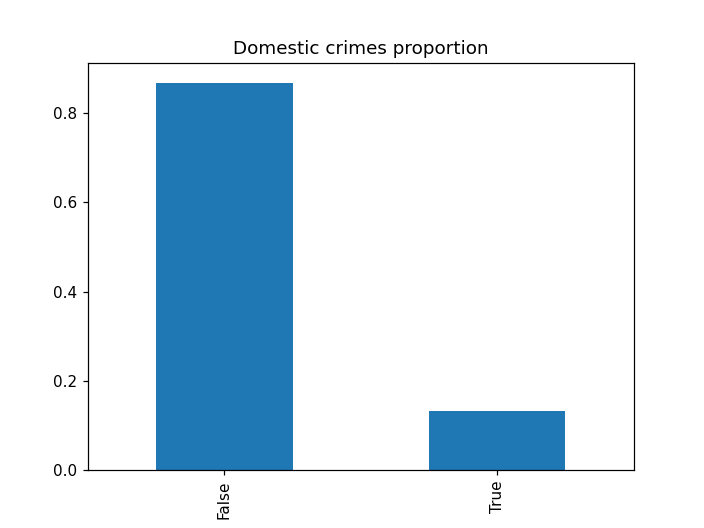

In [56]:
plt.figure()
crimeC['Domestic'].value_counts(normalize=True).plot.bar()
plt.title("Domestic crimes proportion")
plt.show()

In [57]:
domestic = len(crimeC.loc[crimeC['Domestic'] == True, 'Primary Type'].iloc[:])
crimeC.loc[crimeC['Domestic'] == True, 'Primary Type'].iloc[:].unique()

array(['OTHER OFFENSE', 'THEFT', 'DECEPTIVE PRACTICE', 'ROBBERY',
       'BATTERY', 'CRIMINAL DAMAGE', 'ASSAULT', 'MOTOR VEHICLE THEFT',
       'BURGLARY', 'CRIMINAL TRESPASS', 'NARCOTICS'], dtype=object)

Percentatge de crims en domicili respecte el total de crims

In [58]:
domesticRate = (domestic/len(crimeC)) * 100
domesticRate

13.181379659314752

Gràfic per veure l'evolució dels crims en domicilis per any.

<IPython.core.display.Javascript object>


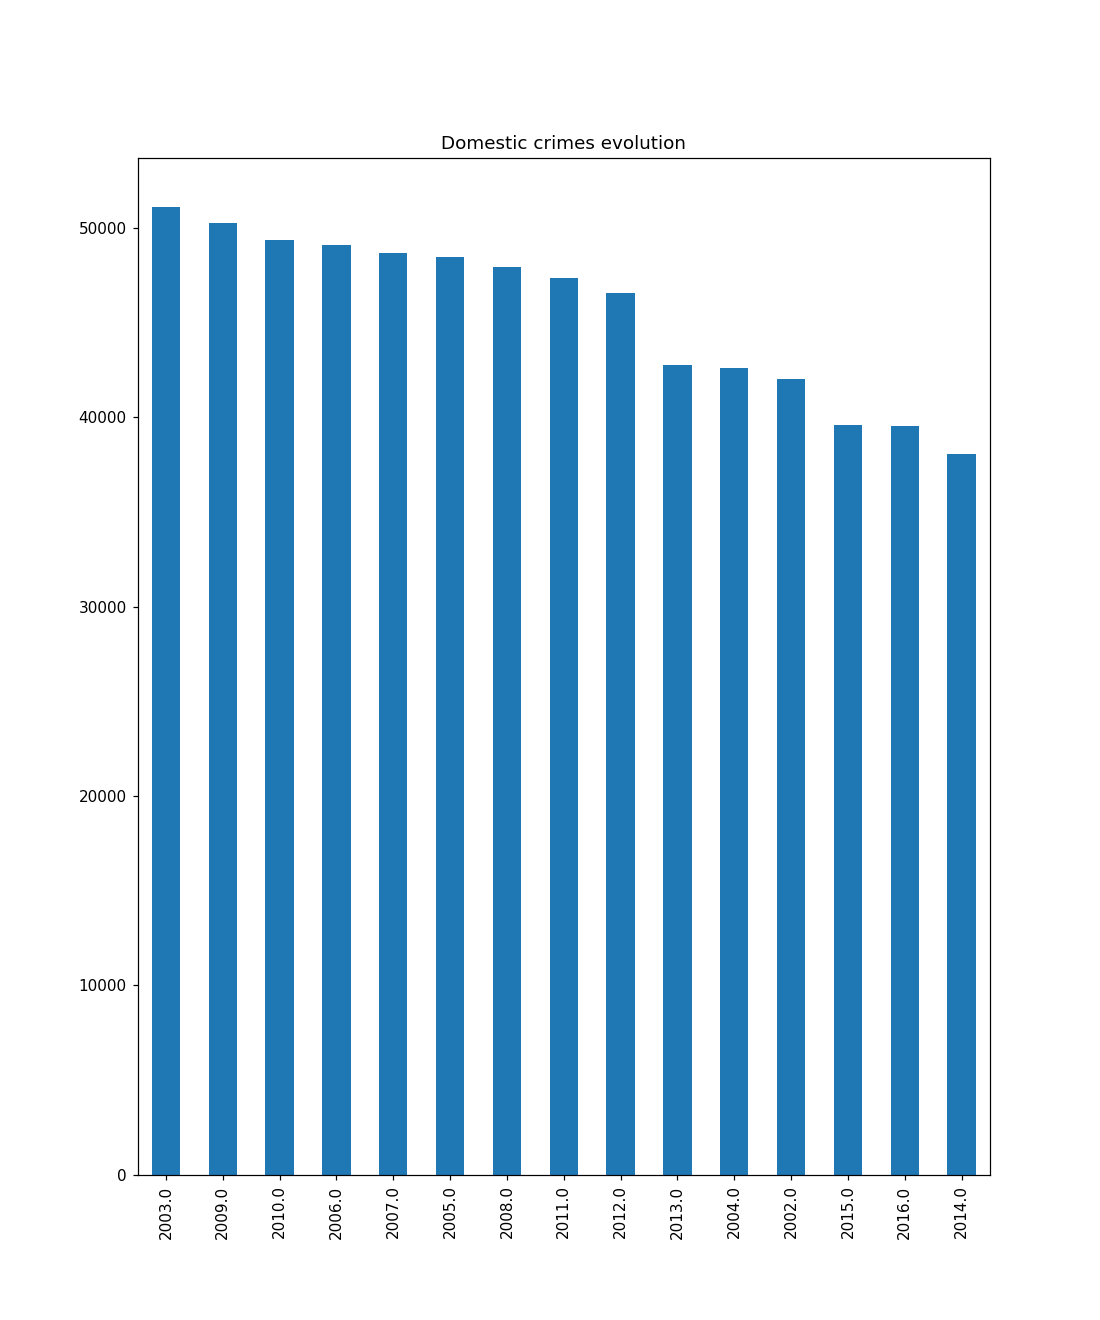

In [59]:
plt.figure(figsize = (10,12))
crimeC.loc[crimeC['Domestic'] == True, 'Year'].iloc[:].value_counts().plot.bar()
plt.title("Domestic crimes evolution")
plt.show()

Transformem les columnes Primary Type i Location Description a numèriques

In [60]:
crimeC['Primary Type'].replace(primaryTypes,lenPrimaryTypes, inplace=True)
crimeC['Location Description'].replace(locationDescription,lenLocationDescription, inplace=True)

In [61]:
crimeC['Primary Type'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [62]:
crimeC['Location Description'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

<IPython.core.display.Javascript object>


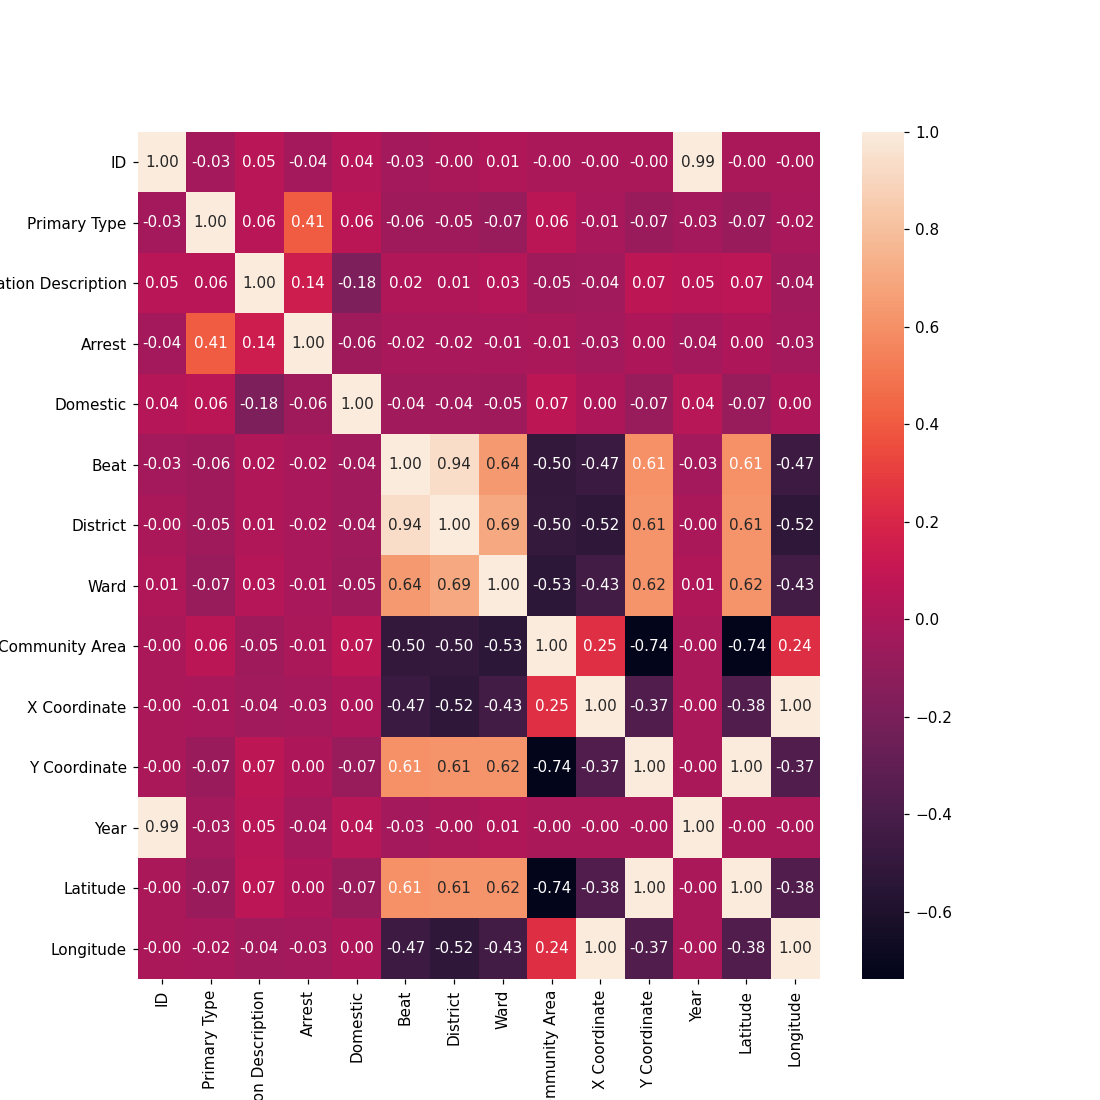

In [63]:
correlacio = crimeC.corr()

plt.figure(figsize = (10,10))

ax = sns.heatmap(correlacio, annot=True, fmt='.2f')
ax.get_figure().savefig("images/correlacioHeatMap.png")

Amb tot això ja podem començar a fer les primeres regressions, per tractar de predir el tipus de crims

In [64]:
crimeC.head()

ID                Date  Primary Type  Location Description  Arrest  \
0  4676906 2003-03-01 00:00:00             0                     0   False   
1  4677901 2003-05-01 01:00:00             1                     0   False   
2  4679521 2003-03-15 00:00:00             0                     1   False   
3  4680124 2003-01-01 00:00:00             1                     0   False   
4  4682244 2003-06-05 00:00:00             1                     0   False   

   Domestic  Beat  District   Ward  Community Area  X Coordinate  \
0      True   935     9.000 11.000          61.000   1173974.000   
1     False  2233    22.000 34.000          49.000   1174948.000   
2     False  2222    22.000 21.000          73.000   1169911.000   
3     False  1134    11.000 24.000          29.000   1154521.000   
4     False  2223    22.000 21.000          73.000   1173946.000   

   Y Coordinate     Year  Latitude  Longitude  
0   1876757.000 2003.000    41.817    -87.637  
1   1831051.000 2003.000    41.692    -87.635  
2   1844832.000 2003.000    41.730    -87.653  
3   1895755.000 2003.000    41.870    -87.708  
4   1842903.000 2003.000    41.724    -87.638

In [65]:
crimeC.to_csv("data/final.csv", index=False)
crimeC = load_dataset("data/final.csv")

C:\Users\adria\AppData\Local\Temp\ipykernel_2796\1449035986.py:31: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dataset = pd.read_csv(path, header=0, delimiter=',', error_bad_lines=False)


In [18]:
Target = "Primary Type"
Classes = crimeC['Primary Type'].unique()

In [24]:
Classes

array(['OTHER OFFENSE', 'THEFT', 'MOTOR VEHICLE THEFT',
       'DECEPTIVE PRACTICE', 'BURGLARY', 'ROBBERY', 'BATTERY',
       'CRIMINAL DAMAGE', 'ASSAULT', 'NARCOTICS', 'CRIMINAL TRESPASS'],
      dtype=object)

In [19]:
crimeC['Primary Type'] = pd.factorize(crimeC["Primary Type"])[0]
crimeC['Location Description'] = pd.factorize(crimeC["Location Description"])[0]

<IPython.core.display.Javascript object>


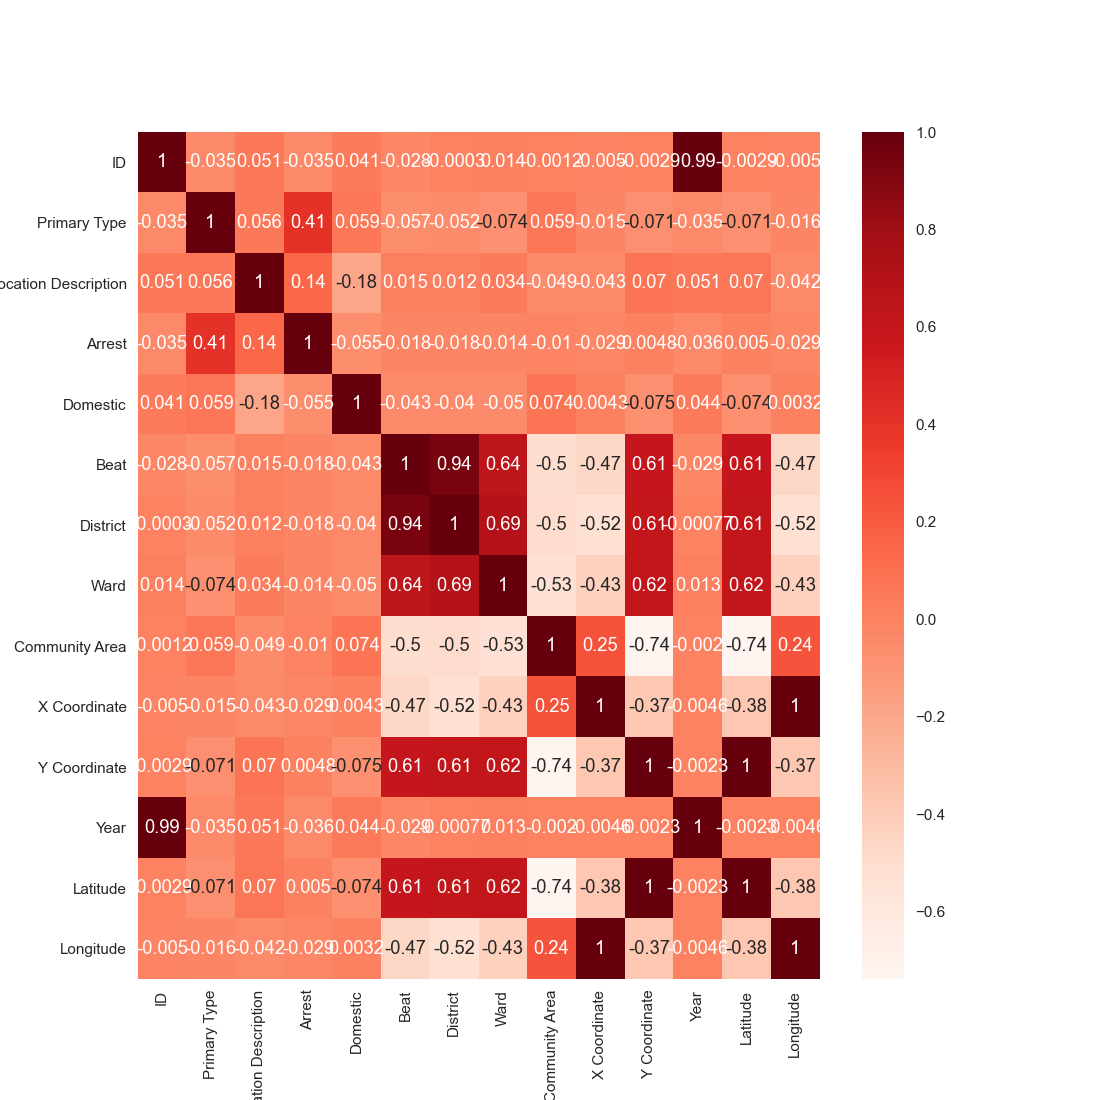

In [27]:
# Feature Selection using Filter Method 
# Split Dataframe to target class and features
X_fs = crimeC.drop(['Primary Type'], axis=1)
Y_fs = crimeC['Primary Type']

#Using Pearson Correlation
plt.figure(figsize=(10,10))
cor = crimeC.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [11]:
# At Current Point, the attributes is select manually based on Feature Selection Part. 
Features = ["Location Description", "Arrest", "Domestic", "Beat", "District", "Ward"]
print('Full Features: ', Features)

Full Features:  ['Location Description', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward']


In [12]:
#Split dataset to Training Set & Test Set
x, y = train_test_split(crimeC, 
                        test_size = 0.2, 
                        train_size = 0.8, 
                        random_state= 3)

x1 = x[Features]    #Features to train
x2 = x[Target]      #Target Class to train
y1 = y[Features]    #Features to test
y2 = y[Target]      #Target Class to test

print('Feature Set Used    : ', Features)
print('Target Class        : ', Target)
print('Training Set Size   : ', x.shape)
print('Test Set Size       : ', y.shape)

Feature Set Used    :  ['Location Description', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward']
Target Class        :  Primary Type
Training Set Size   :  (4146983, 15)
Test Set Size       :  (1036746, 15)


In [13]:
# Random Forest
# Create Model with configuration
rf_model = RandomForestClassifier(n_estimators=70, # Number of trees
                                  min_samples_split = 30,
                                  bootstrap = True, 
                                  max_depth = 50, 
                                  min_samples_leaf = 25)

# Model Training
rf_model.fit(X=x1,
             y=x2)

# Prediction
result = rf_model.predict(y[Features])

In [14]:
# Model Evaluation
ac_sc = accuracy_score(y2, result)
rc_sc = recall_score(y2, result, average="weighted")
pr_sc = precision_score(y2, result, average="weighted")
f1_sc = f1_score(y2, result, average='micro')
confusion_m = confusion_matrix(y2, result)

print("========== Random Forest Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

========== Random Forest Results ==========
Accuracy    :  0.4642178508525714
Recall      :  0.4642178508525714
Precision   :  0.4249807304075344
F1 Score    :  0.4642178508525714
Confusion Matrix: 
[[  6369  16499    591    144  10101     73  20470   5410     27   7577
     383]
 [  3802 169449   4052   1328  15414   1061  16632   9867     96   4263
    1802]
 [    76  36627   4972     61    530    271   1520   2649      2   3926
     219]
 [  2157  18105    110   6603   4565     63   1335   2415      9   2716
     782]
 [  3147  15237     11     68  36173     36   2318   6789     10   1448
     414]
 [    72  19204   1202    405    885   2341  13413    937     37   2772
     383]
 [  2172  39037   1868    291   9419   1736 121958   5364    156  14972
    2588]
 [  3024  63580   3865    348  20642    631  16024  13059     45   4537
     941]
 [  1032  19601    881    227   4504    665  27455   2931    160   8000
    1534]
 [   192    864     41    484    167     20   4128     63     1

<IPython.core.display.Javascript object>


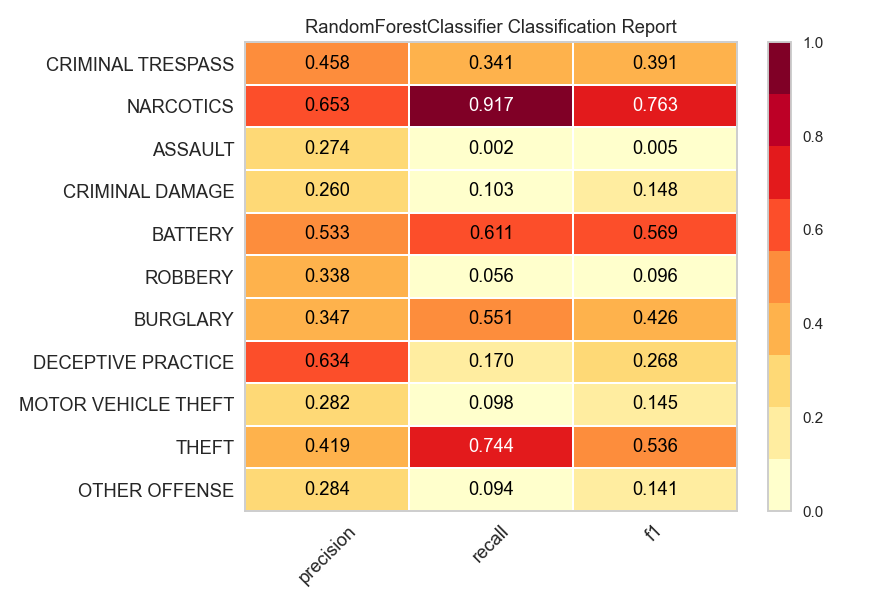

C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [32]:
# Classification Report
# Instantiate the classification model and visualizer
target_names = Classes
plt.figure()
visualizer = ClassificationReport(rf_model, classes=target_names)
visualizer.fit(X=x1, y=x2)     # Fit the training data to the visualizer
visualizer.score(y1, y2)       # Evaluate the model on the test data

g = visualizer.poof()             # Draw/show/poof the data

In [29]:
# Neural Network
# Create Model with configuration 
nn_model = MLPClassifier(solver='adam', 
                         alpha=1e-5,
                         hidden_layer_sizes=(40,), 
                         random_state=1,
                         max_iter=1000                         
                        )

# Model Training
nn_model.fit(X=x1,
             y=x2)

# Prediction
result = nn_model.predict(y[Features]) 

In [30]:
# Model Evaluation
ac_sc = accuracy_score(y2, result)
rc_sc = recall_score(y2, result, average="weighted")
pr_sc = precision_score(y2, result, average="weighted")
f1_sc = f1_score(y2, result, average='micro')
confusion_m = confusion_matrix(y2, result)

print("========== Neural Network Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


========== Neural Network Results ==========
Accuracy    :  0.40121206158499767
Recall      :  0.40121206158499767
Precision   :  0.3469411857989667
F1 Score    :  0.40121206158499767
Confusion Matrix: 
[[  7096  14641   2035      0  15046      0  20071      2      0   8290
     463]
 [  7037 151248  25342     27  21664      0  10027      0      0  11704
     717]
 [    92  30288  15158      0    469      0    582      0      0   4236
      28]
 [  4226  20520   2080     73   6467      0    712      0      0   4427
     355]
 [  6643  27378     74      1  27382      0   1108      0      0   2417
     648]
 [    92  22312   4109      6   1591      0  10071      0      0   3347
     123]
 [  2110  51532   7315     16  14940      0 101096     19      0  19852
    2681]
 [  5329  63753  16413      5  23987      0  10791      8      0   5714
     696]
 [  1159  24053   3443      9   8121      0  19157      2      0   9982
    1064]
 [     8   6018     61      7    111      0    226      0  

<IPython.core.display.Javascript object>


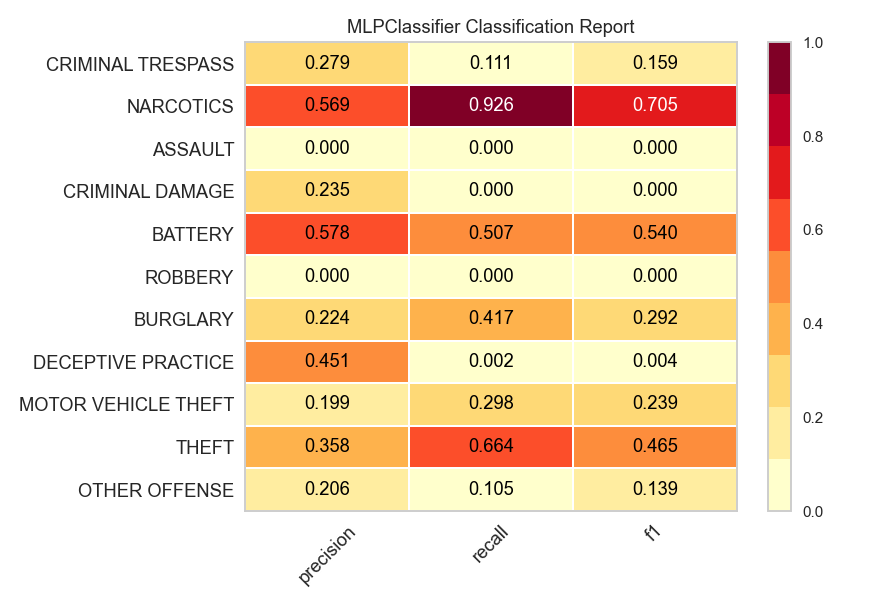

C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
# Classification Report
# Instantiate the classification model and visualizer
target_names = Classes
plt.figure()
visualizer = ClassificationReport(nn_model, classes=target_names)
visualizer.fit(X=x1, y=x2)     # Fit the training data to the visualizer
visualizer.score(y1, y2)       # Evaluate the model on the test data

g = visualizer.poof()       

In [34]:
# K-Nearest Neighbors
# Create Model with configuration 
knn_model = KNeighborsClassifier(n_neighbors=3)

# Model Training
knn_model.fit(X=x1,
             y=x2)

# Prediction
result = knn_model.predict(y[Features]) 

In [35]:
# Model Evaluation
ac_sc = accuracy_score(y2, result)
rc_sc = recall_score(y2, result, average="weighted")
pr_sc = precision_score(y2, result, average="weighted")
f1_sc = f1_score(y2, result, average='micro')
confusion_m = confusion_matrix(y2, result)

print("========== K-Nearest Neighbors Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

========== K-Nearest Neighbors Results ==========
Accuracy    :  0.3758075748544002
Recall      :  0.3758075748544002
Precision   :  0.3638402094129815
F1 Score    :  0.3758075748544002
Confusion Matrix: 
[[ 18840  13896   1424   2323   4728    563  15006   4298   1105   5208
     253]
 [ 21423 132363  13510   6433   9462   4821  16690  17254   2214   2283
    1313]
 [  3643  23238   9388    634    404   1289   2927   6431    364   2410
     125]
 [  6449  14271    739   8356   2191    525   2124   2002    331   1539
     333]
 [ 13752  18613    497   2537  18418    342   4066   5981    569    533
     343]
 [  2192  14957   3516   1165    758   5528   8127   2360   1114   1751
     183]
 [ 25416  37851   6116   3138   6199   8368  86856   8578   6135   9412
    1492]
 [ 17165  48281   9791   3221  11123   2447  14925  15062   1621   2471
     589]
 [  8035  17459   2705   1554   2962   3044  19348   3670   2271   4977
     965]
 [  6761   4018   2667   2159   1268   1246   8885   1362

<IPython.core.display.Javascript object>


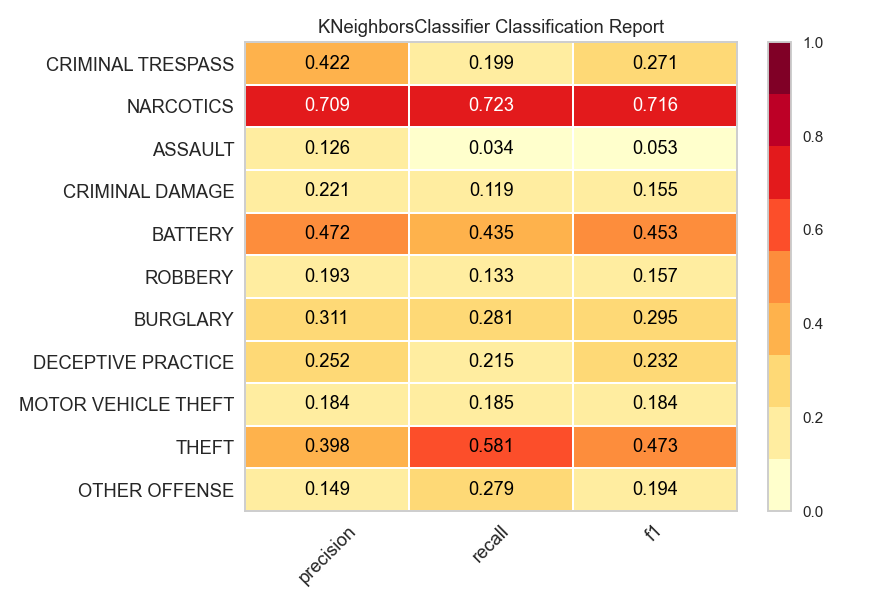

C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [36]:
# Classification Report
# Instantiate the classification model and visualizer
target_names = Classes
plt.figure()
visualizer = ClassificationReport(knn_model, classes=target_names)
visualizer.fit(X=x1, y=x2)     # Fit the training data to the visualizer
visualizer.score(y1, y2)       # Evaluate the model on the test data

g = visualizer.poof()    

In [92]:
import math

def mean_squeared_error(y1, y2):
    # comprovem que y1 i y2 tenen la mateixa mida
    assert(len(y1) == len(y2))
    mse = 0
    for i in range(len(y1)):
        mse += (y1[i] - y2[i])**2
    return mse / len(y1)

mean_squeared_error([1,2,3,4], [1,2,1,4])

1.0

In [93]:
import numpy as np #importem la llibreria
np.warnings.filterwarnings('ignore')

vector1 = np.array([1,2,3,4]) # convertim llista de python a numpy array
vector2 = np.array([1,2,1,4]) 

# podem sumar dos vectors element a element
print("Suma vector1 + vector2 ", vector1 + vector2)

# podem sumar tots els valors d'un vector
print("Suma valors vector1 ", vector1.sum())

# calculem la mitjana
print("Mitjana vector1", vector1.mean())

# utilitzem un vector com a índex de l'altre
# vector3 = vector1  # necesitem fer una copia del vector per no modificar el original
vector3 = vector1.copy()
vector3[vector2 == 1] = 5
print("Vector1 amb un 5 on el Vector2 te 1s ", vector3)

# es pot utilitzar numpy per a calcular el mse
def mse(v1, v2):
    return ((v1 - v2)**2).mean()

print("MSE: ", mse(vector1, vector2))

Suma vector1 + vector2  [2 4 4 8]
Suma valors vector1  10
Mitjana vector1 2.5
Vector1 amb un 5 on el Vector2 te 1s  [5 2 5 4]
MSE:  1.0


Per a la regressió podeu utilitzar la llibreria sklearn:

In [94]:
from sklearn.linear_model import LinearRegression

def regression(x, y):
    # Creem un objecte de regressió de sklearn
    regr = LinearRegression()

    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)

    # Retornem el model entrenat
    return regr

Finalment, si la funció `fit` del regressor logístic dónes l'error: `ValueError: Unknown label type: 'unknown'`, caldria afegir a la definició de l'atribut a trobar $y$ la crida a la funció `.astype('int')` per tal de obligar a que les dades siguin de tipus sencer, deixant el codi com segueix:

`y = data[:,2].astype('int')`

A continuació, es modificaran tots els atributs mitjançant **procediments de normalització (normal, estàndard)**, i s'avaluarà el rendiment del regressor après. Per a això, caldrà analitzar la mitja i variança de cada variable per totes les mostres, per identificar aquells valors que tenen una distribució normal, els preferits per fer regressió, i descartar altres atributs que no són representatius per fer la regressió, i que afegeixen soroll al model. 

Pel que fa a l'error resultant de la regressió, recordeu que es calcula fent la diferència entre el valor predit i el real al quadrat: així doncs, si les dades tenen valors grans (tipus 10^3), l'error al quadrat podria acabar sent 10^6. Per això és important normalitzar abans (escalar les dades a un rang més petit).

<img src="images/standarization.png">

Podeu estandarditzar les dades amb les funcions mean i std de numpy i mostrar l'hisotgrama de nou. Recuperant l'exemple de l'apartat anterior:

In [95]:
def standarize(x_train):
    mean = x_train.mean(0)
    std = x_train.std(0)
    x_t = x_train - mean[None, :]
    x_t /= std[None, :]
    return x_t

#x_t = standarize(x)

Regressió sense normalitzar

In [96]:
y = crimeC.iloc[:,2]

In [97]:
crimeC = crimeC.drop(['ID', 'Date'], axis=1)

(5183729, 13)


<IPython.core.display.Javascript object>


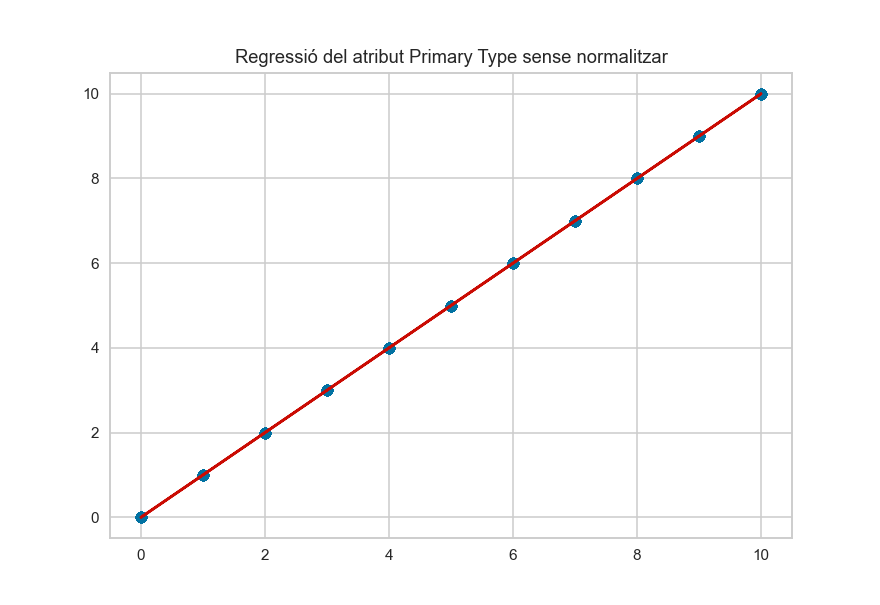

Mean squeared error  Primary Type :  1.2015254370620705e-26
R2 score:  1.0


<IPython.core.display.Javascript object>


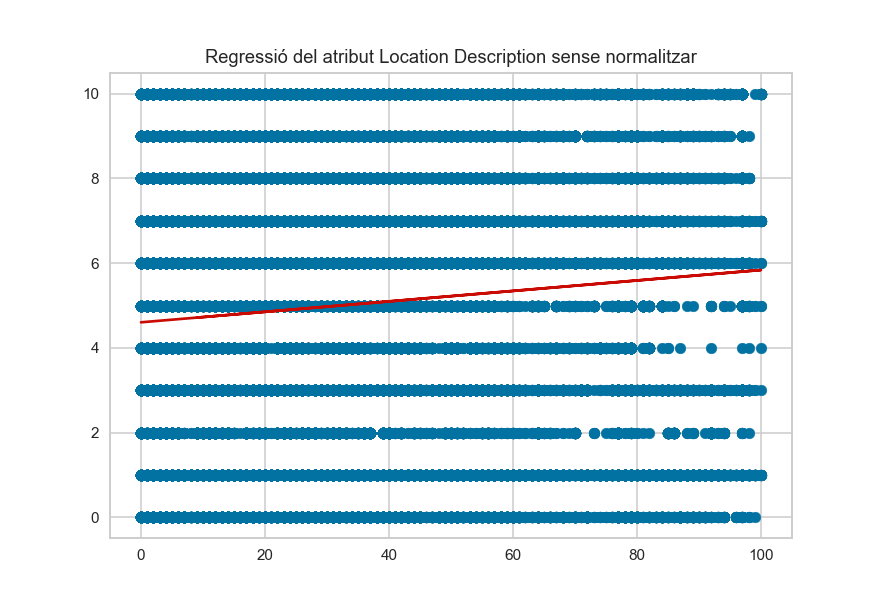

Mean squeared error  Location Description :  9.588863417255045
R2 score:  0.003140015170046917


<IPython.core.display.Javascript object>


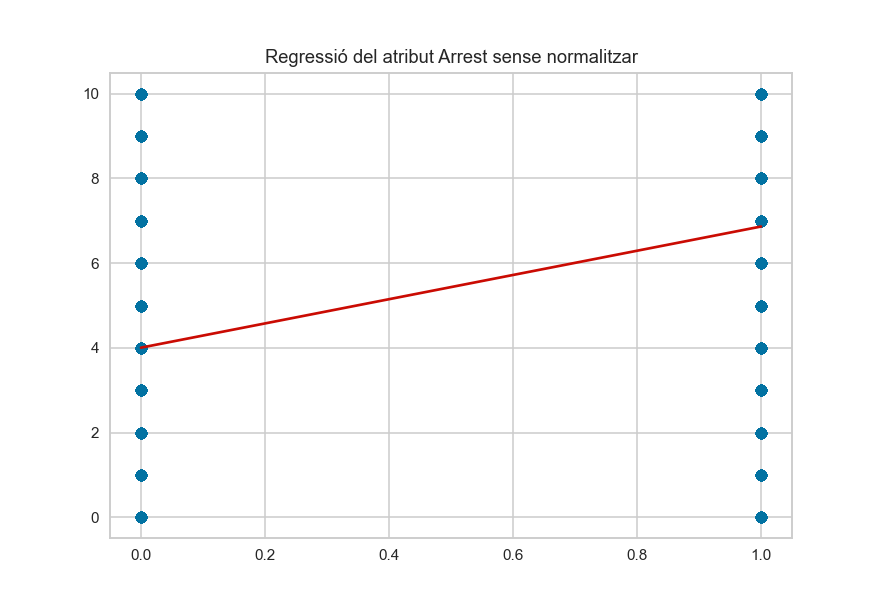

Mean squeared error  Arrest :  8.038097980950898
R2 score:  0.1643578719732991


<IPython.core.display.Javascript object>


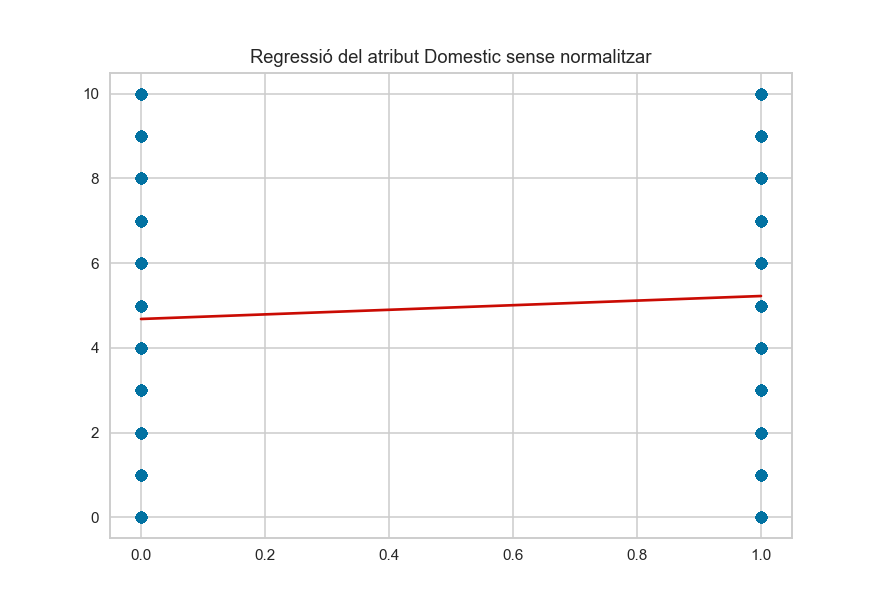

Mean squeared error  Domestic :  9.58541333288775
R2 score:  0.003498686568354059


<IPython.core.display.Javascript object>


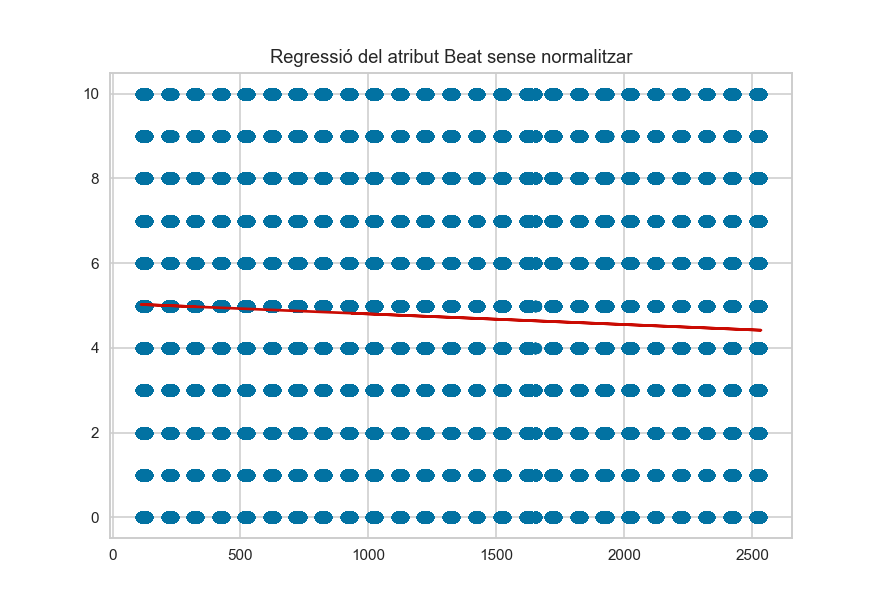

Mean squeared error  Beat :  9.587926769658866
R2 score:  0.0032373892244982327


<IPython.core.display.Javascript object>


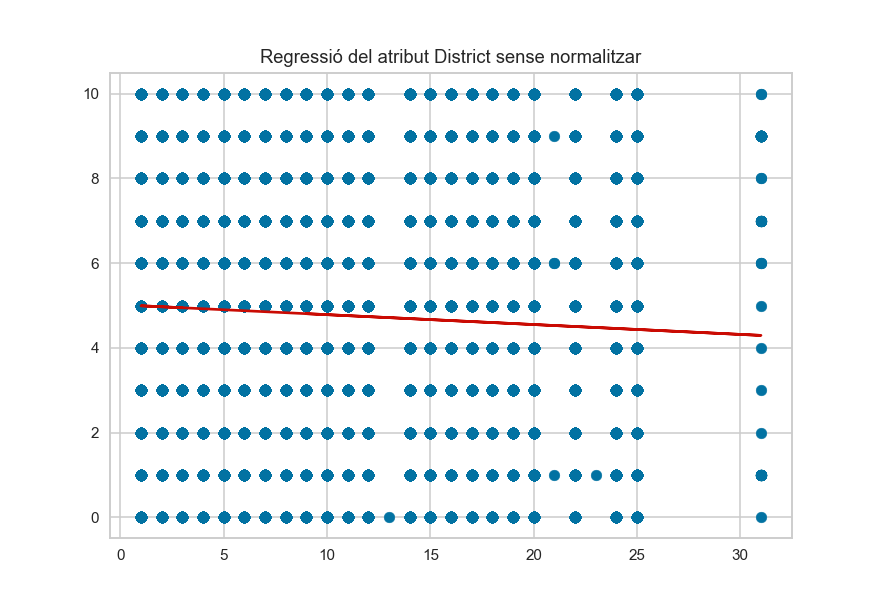

Mean squeared error  District :  9.592866199659037
R2 score:  0.002723885183322894


<IPython.core.display.Javascript object>


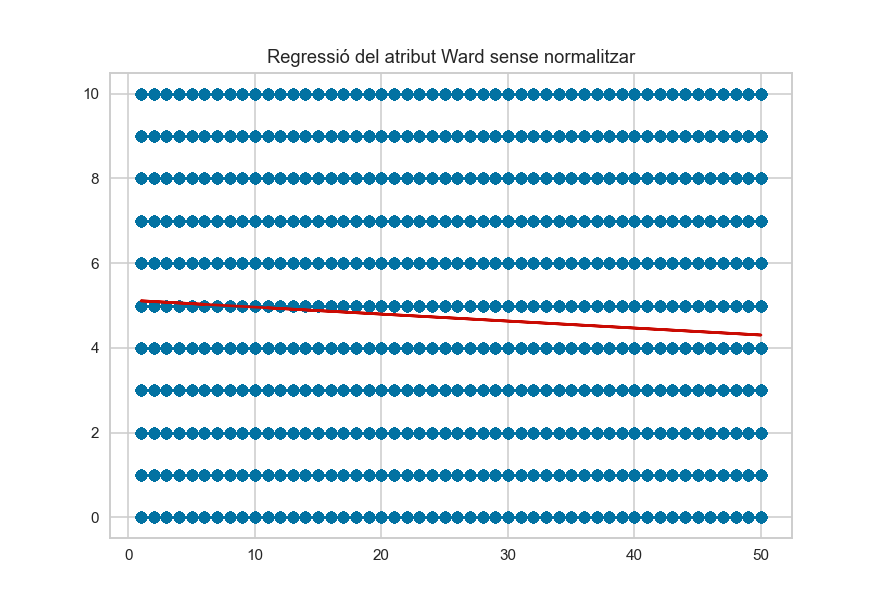

Mean squeared error  Ward :  9.566997188030825
R2 score:  0.005413232337111773


<IPython.core.display.Javascript object>


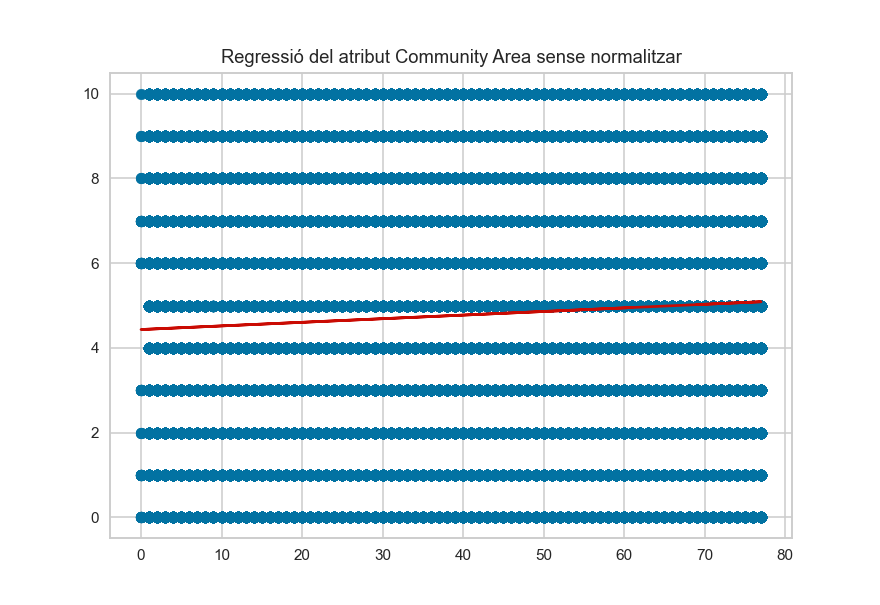

Mean squeared error  Community Area :  9.585295713081033
R2 score:  0.0035109143448525115


<IPython.core.display.Javascript object>


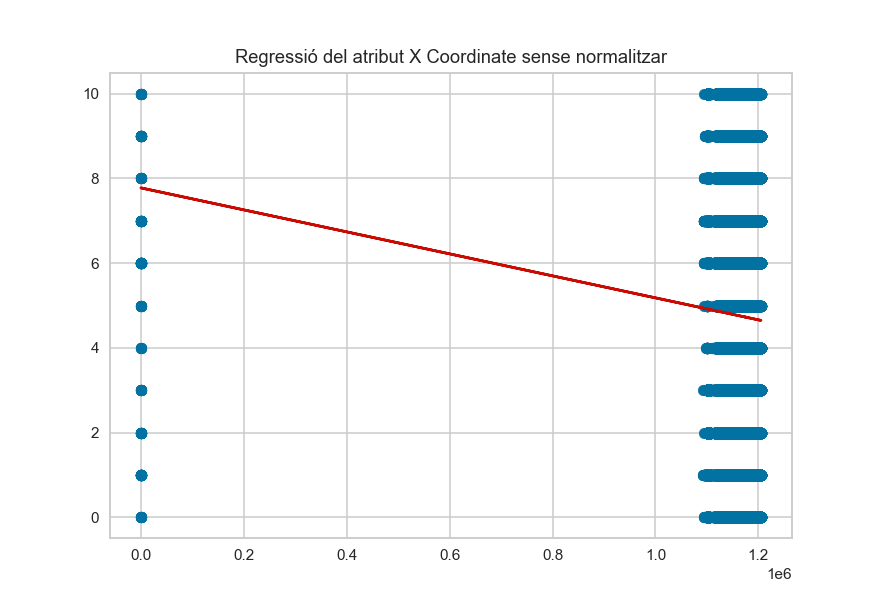

Mean squeared error  X Coordinate :  9.617001549828633
R2 score:  0.00021476979008105967


<IPython.core.display.Javascript object>


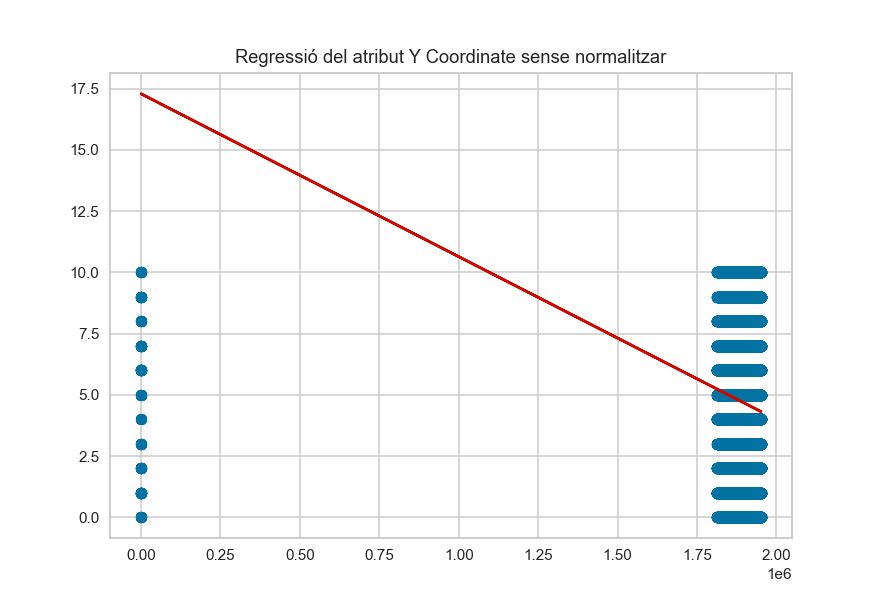

Mean squeared error  Y Coordinate :  9.570339604822651
R2 score:  0.0050657540795322475


<IPython.core.display.Javascript object>


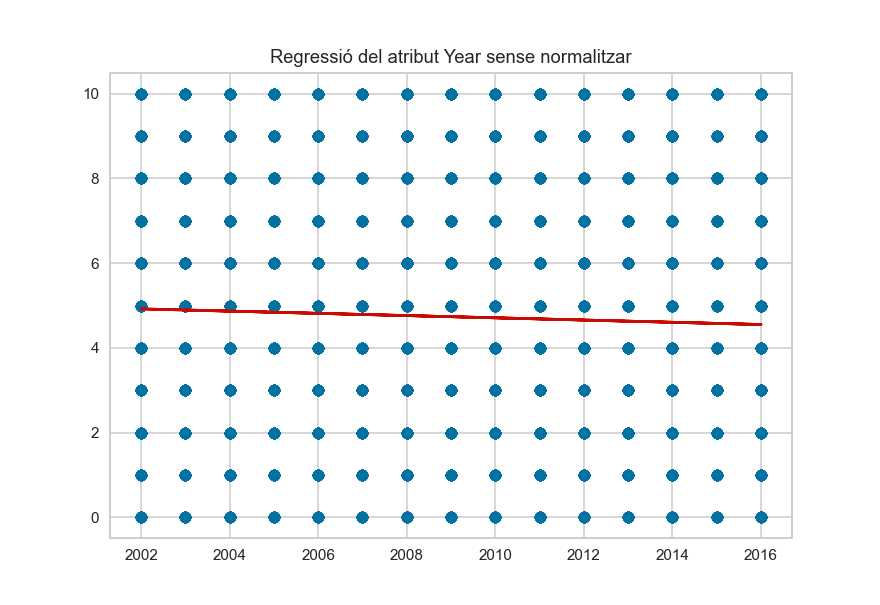

Mean squeared error  Year :  9.607345231280824
R2 score:  0.0012186424225516523


<IPython.core.display.Javascript object>


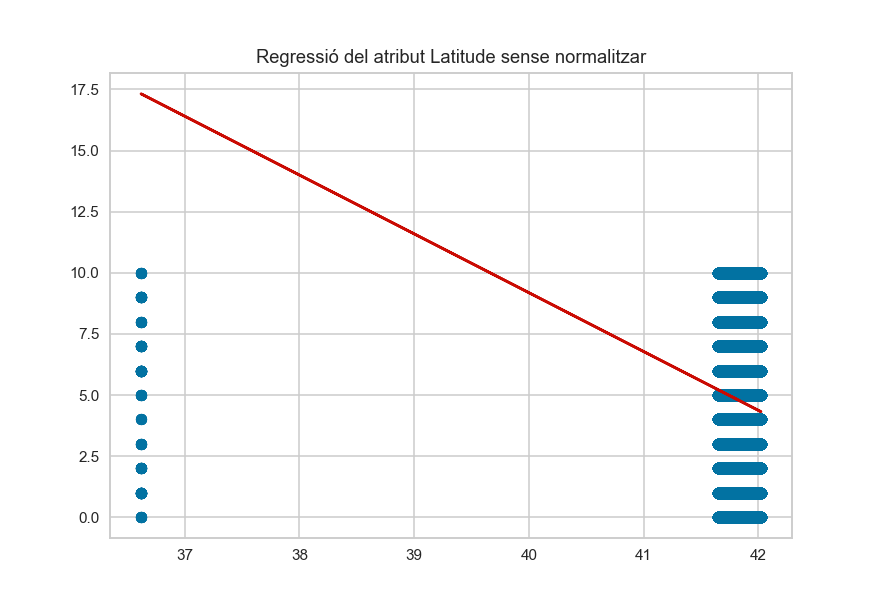

Mean squeared error  Latitude :  9.570706673424597
R2 score:  0.005027593560913424


<IPython.core.display.Javascript object>


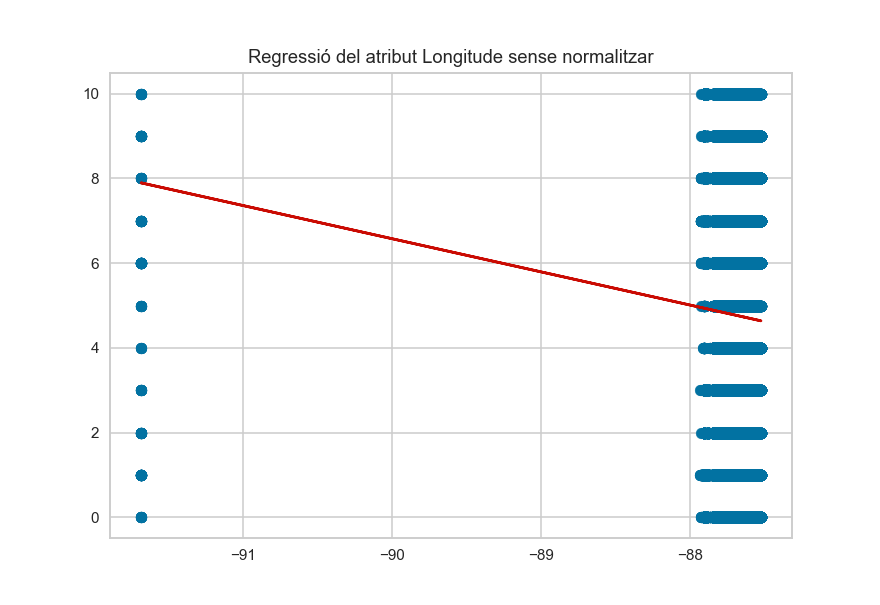

Mean squeared error  Longitude :  9.616614844349657
R2 score:  0.00025497176200728333


In [98]:
##dataset fill 0
from sklearn.metrics import r2_score

index = crimeC.columns[:]
print(crimeC.shape)
# Extraiem el primer atribut de x i canviem la mida a #exemples, #dimensions de l'atribut.
# En el vostre cas, haureu de triar un atribut com a y, i utilitzar la resta com a x.
for index1 in range(crimeC.shape[1]):
    atribut1 = crimeC.iloc[:,index1].values.reshape(crimeC.shape[0], 1) 
    regr = regression(atribut1, y) 
    predicted = regr.predict(atribut1)

    # Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
    plt.figure()
    plt.title("Regressió del atribut {} sense normalitzar".format(index[index1]))
    ax = plt.scatter(crimeC.iloc[:,index1], y)
    plt.plot(atribut1[:,0], predicted, 'r')

    # Mostrem l'error (MSE i R2)
    MSE = mse(y, predicted)
    r2 = r2_score(y, predicted)

    print("Mean squeared error ",index[index1],": ", MSE)
    print("R2 score: ", r2)

Amb estandarització

<IPython.core.display.Javascript object>


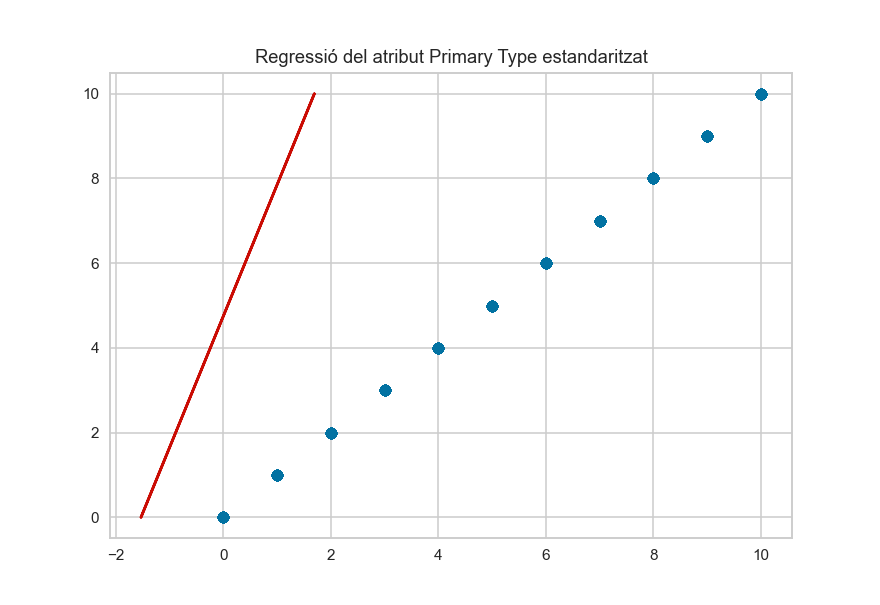

Mean squeared error  Primary Type :  7.192051166190863e-22
R2 score:  1.0


<IPython.core.display.Javascript object>


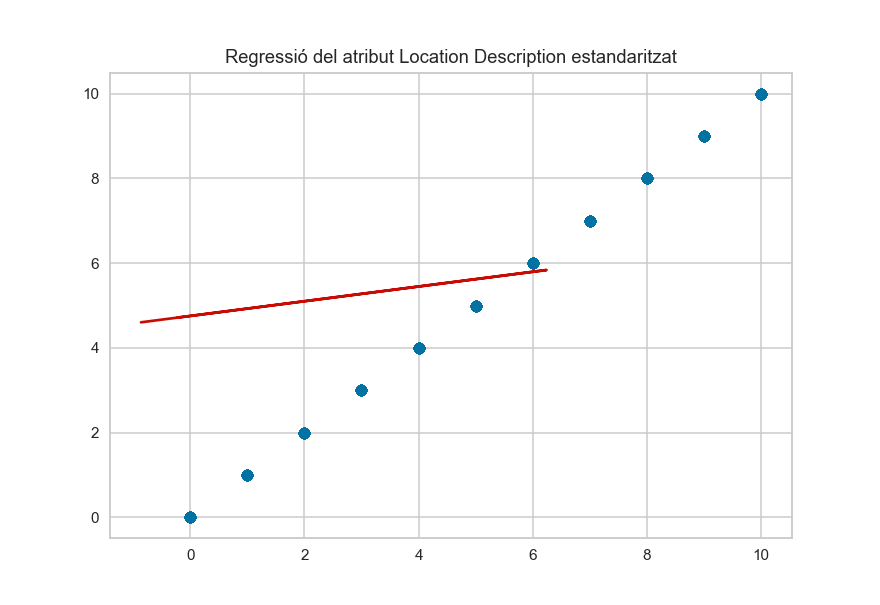

Mean squeared error  Location Description :  9.588863417255043
R2 score:  0.003140015170047139


<IPython.core.display.Javascript object>


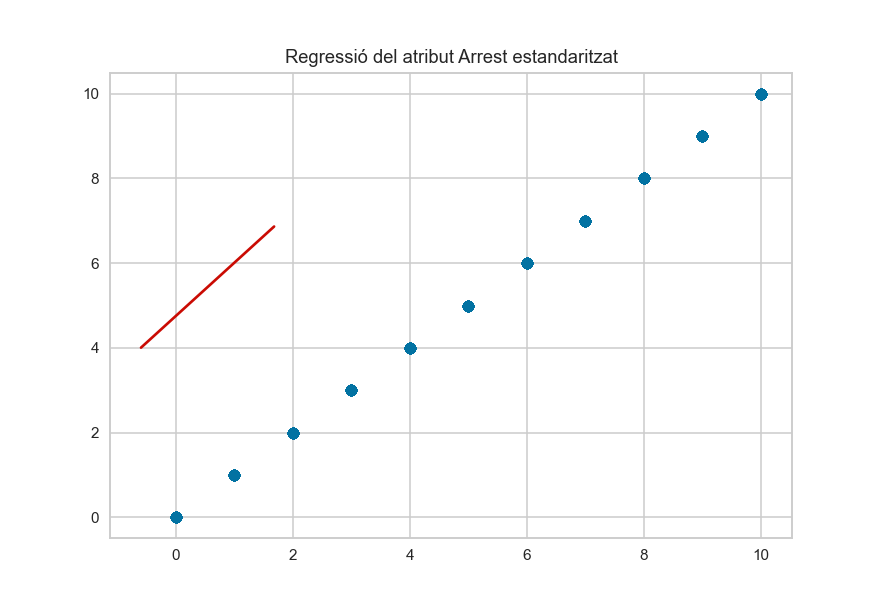

Mean squeared error  Arrest :  8.038097980950898
R2 score:  0.1643578719732991


<IPython.core.display.Javascript object>


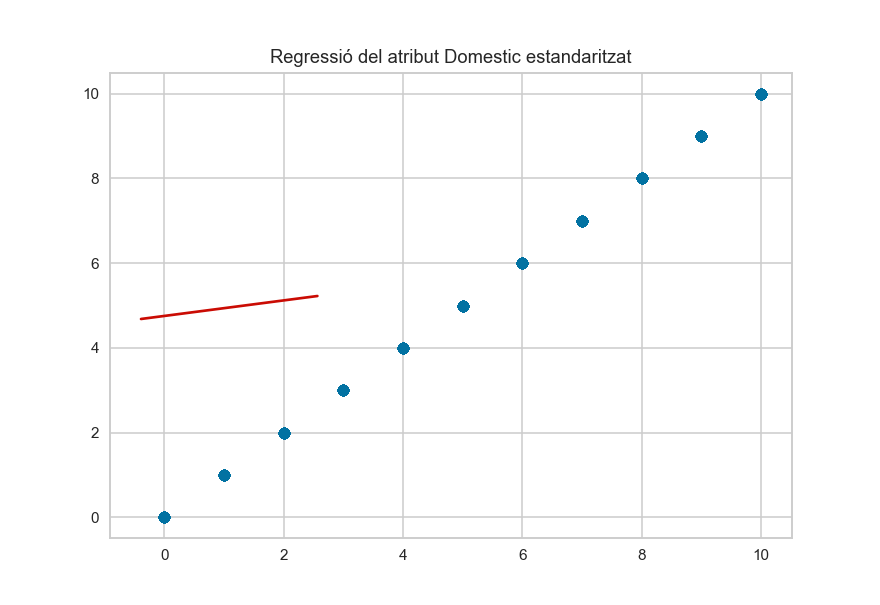

Mean squeared error  Domestic :  9.585413332887752
R2 score:  0.003498686568353948


<IPython.core.display.Javascript object>


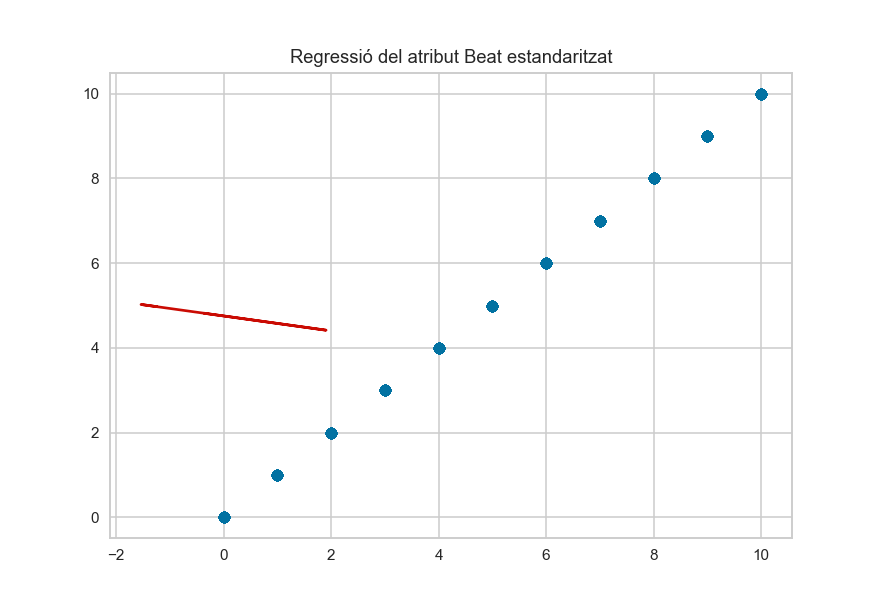

Mean squeared error  Beat :  9.587926769658862
R2 score:  0.003237389224498566


<IPython.core.display.Javascript object>


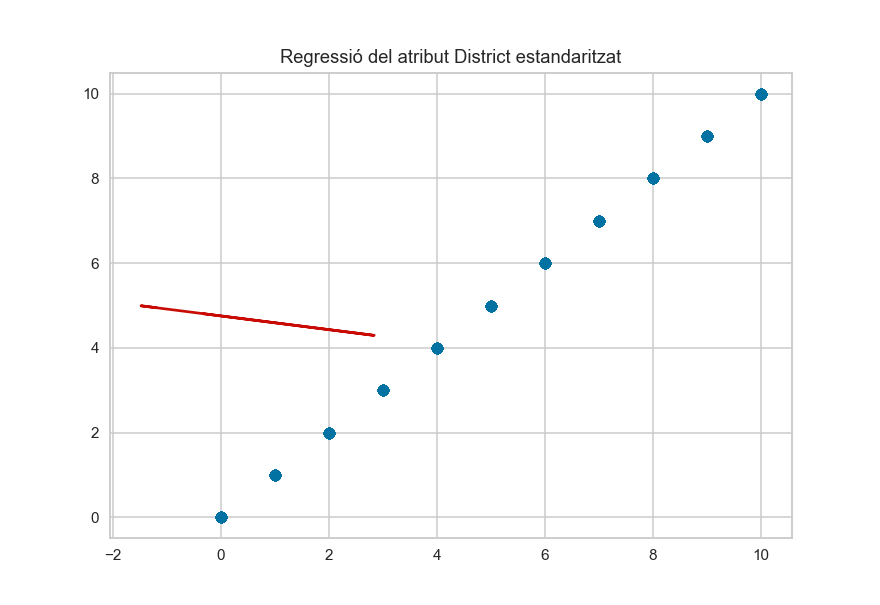

Mean squeared error  District :  9.592866199659033
R2 score:  0.002723885183323227


<IPython.core.display.Javascript object>


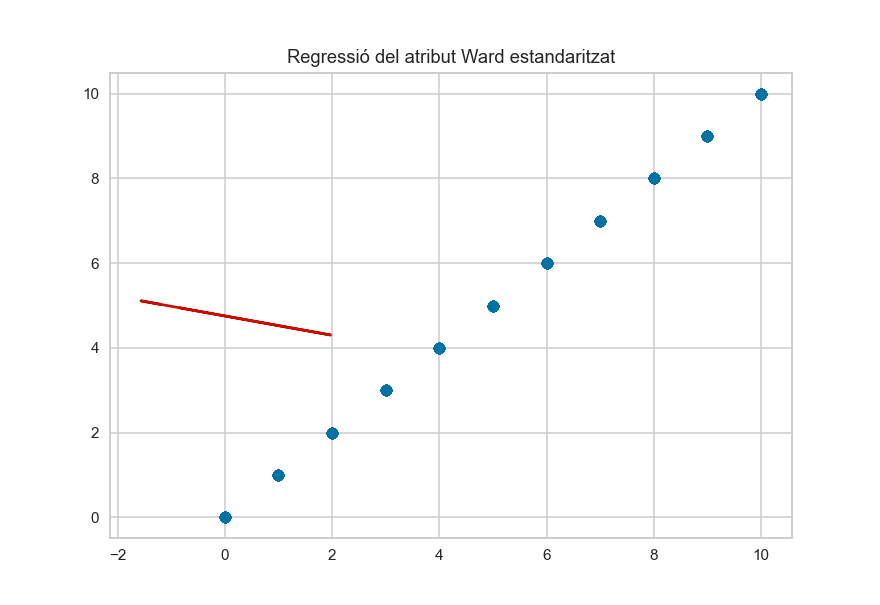

Mean squeared error  Ward :  9.566997188030827
R2 score:  0.005413232337111662


<IPython.core.display.Javascript object>


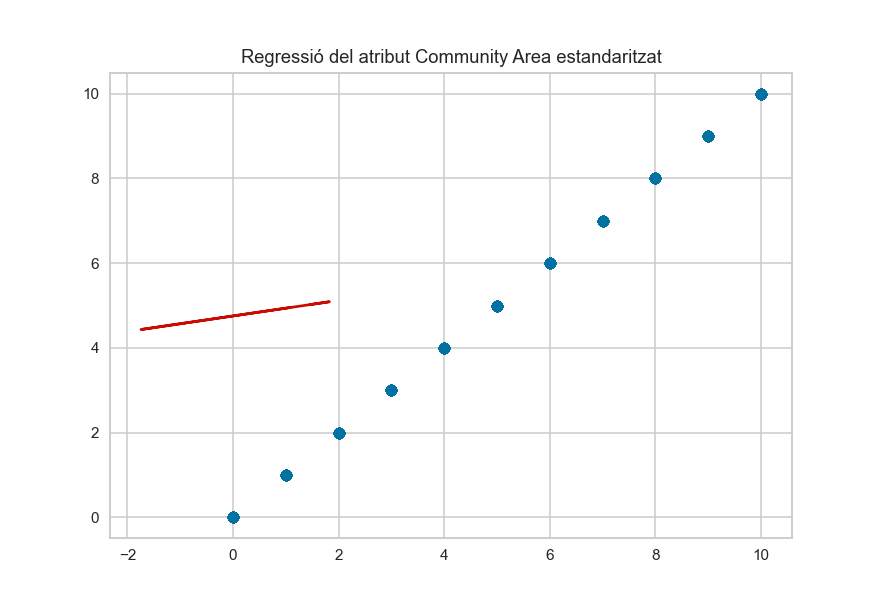

Mean squeared error  Community Area :  9.58529571308103
R2 score:  0.0035109143448529556


<IPython.core.display.Javascript object>


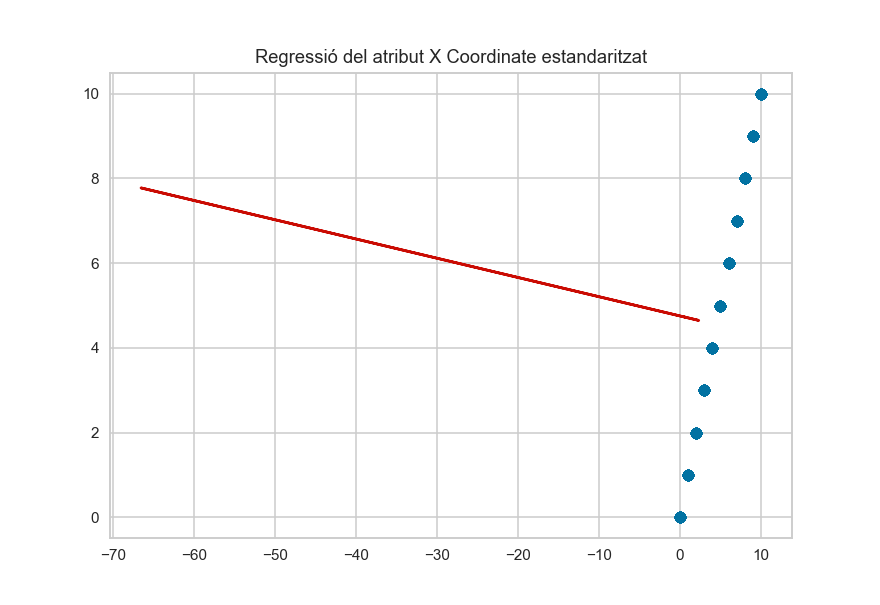

Mean squeared error  X Coordinate :  9.617001549828633
R2 score:  0.00021476979008105967


<IPython.core.display.Javascript object>


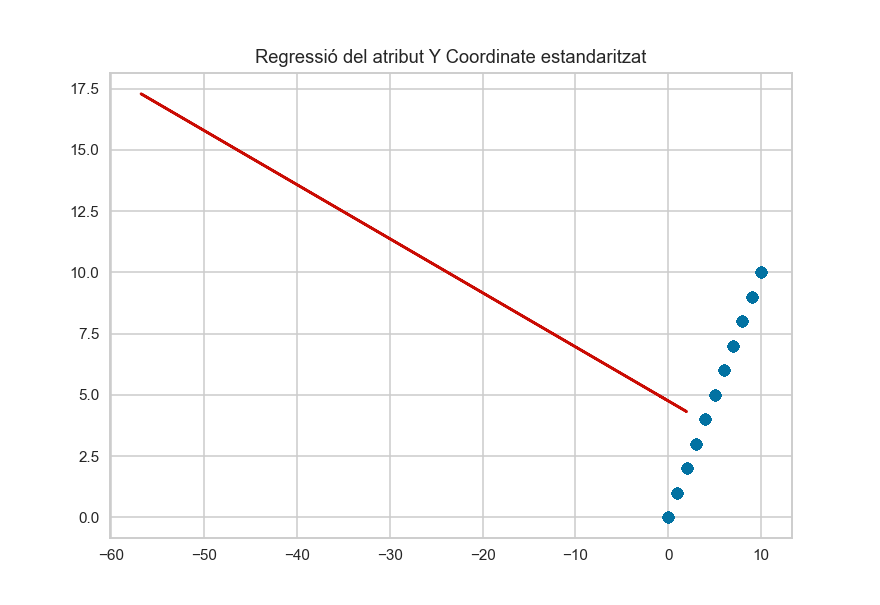

Mean squeared error  Y Coordinate :  9.570339604822648
R2 score:  0.005065754079532581


<IPython.core.display.Javascript object>


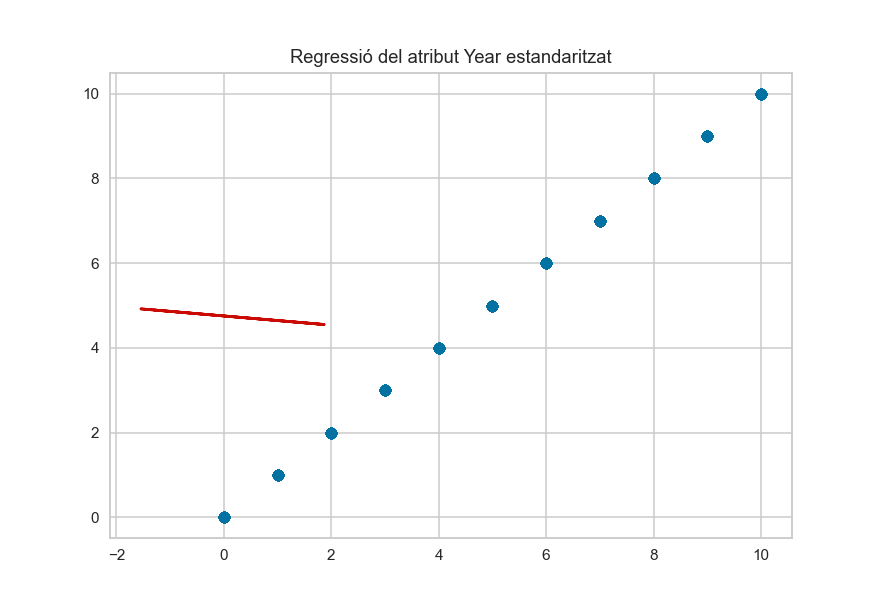

Mean squeared error  Year :  9.607345231280805
R2 score:  0.0012186424225535397


<IPython.core.display.Javascript object>


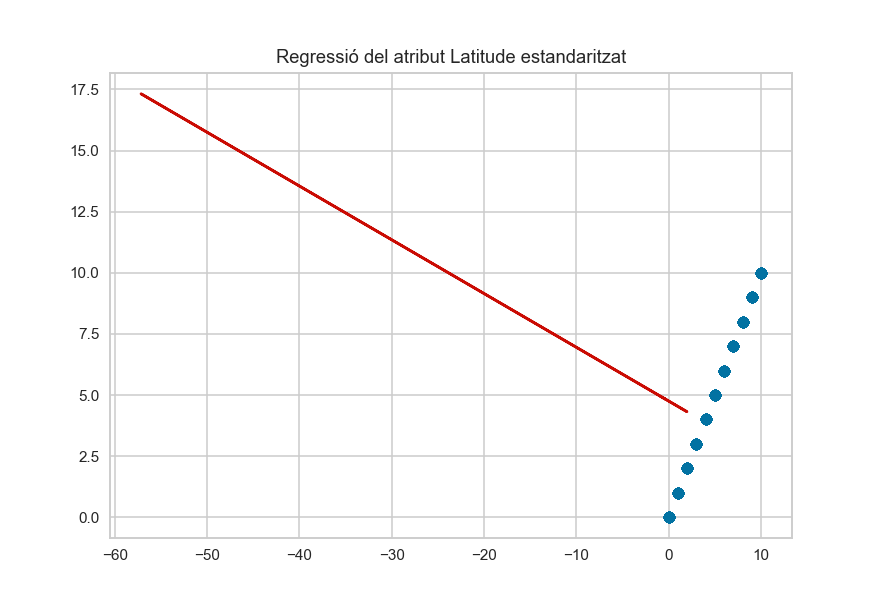

Mean squeared error  Latitude :  9.570706673424606
R2 score:  0.0050275935609125355


<IPython.core.display.Javascript object>


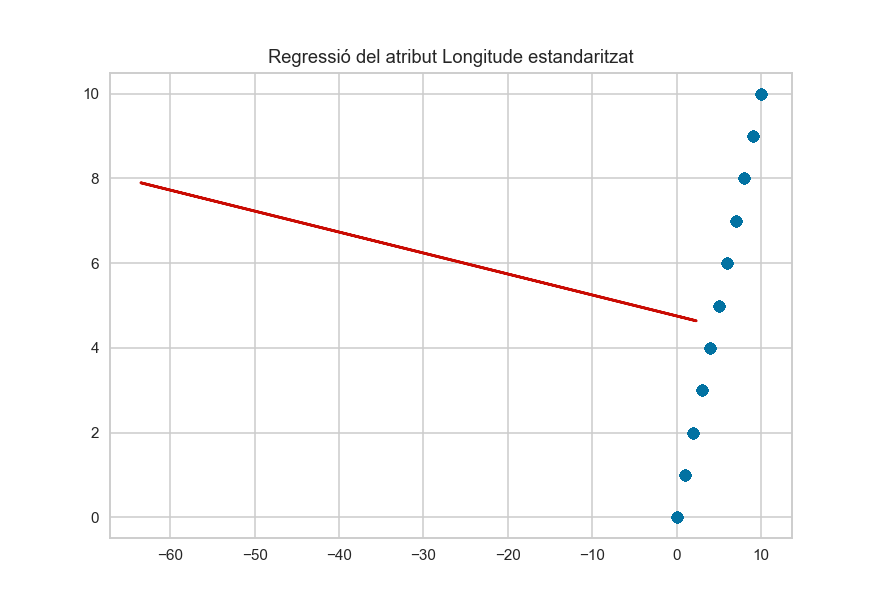

Mean squeared error  Longitude :  9.61661484434966
R2 score:  0.00025497176200683924


In [99]:
from sklearn.metrics import r2_score

# Extraiem el primer atribut de x i canviem la mida a #exemples, #dimensions de l'atribut.
# En el vostre cas, haureu de triar un atribut com a y, i utilitzar la resta com a x.
for index2 in range(crimeC.shape[1]):
    index1 = index2
    atribut1 = crimeC.iloc[:,index1].values.reshape(crimeC.shape[0], 1) 
    atribut1 = standarize(atribut1)
    regr = regression(atribut1, y) 
    predicted = regr.predict(atribut1)

    # Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
    plt.figure()
    plt.title("Regressió del atribut {} estandaritzat".format(index[index1]))
    ax = plt.scatter(crimeC.iloc[:,0], y)
    plt.plot(atribut1[:,0], predicted, 'r')

    # Mostrem l'error (MSE i R2)
    MSE = mse(y, predicted)
    r2 = r2_score(y, predicted)

    print("Mean squeared error ",index[index1],": ", MSE)
    print("R2 score: ", r2)

Un cop mostrats de manera adient, (en forma de taula, i/o de gràfics si la dimensionalitat ho permet) els resultats aconseguits amb la regressió, avaluarem de manera independent la idonietat de cadascun dels atributs.

In [100]:
""" Per a assegurar-nos que el model s'ajusta be a dades noves, no vistes, 
cal evaluar-lo en un conjunt de validacio (i un altre de test en situacions reals).
Com que en aquest cas no en tenim, el generarem separant les dades en 
un 80% d'entrenament i un 20% de validació.
"""
def split_data(x, y, train_ratio=0.7):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_val = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_val = x[indices_val, :]
    y_val = y[indices_val]
    return x_train, y_train, x_val, y_val

# Dividim dades d'entrenament
x_train, y_train, x_val, y_val = split_data(x, y)

for i in range(x_train.shape[1]):
    x_t = x_train[:,i] # seleccionem atribut i en conjunt de train
    x_v = x_val[:,i] # seleccionem atribut i en conjunt de val.
    x_t = np.reshape(x_t,(x_t.shape[0],1))
    x_v = np.reshape(x_v,(x_v.shape[0],1))

    regr = regression(x_t, y_train)    
    error = mse(y_val, regr.predict(x_v)) # calculem error
    r2 = r2_score(y_val, regr.predict(x_v))
    
    # Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
    plt.figure()
    plt.title("Regressió del atribut {}".format(index[i]))
    ax = plt.scatter(x[:,i], y)
    plt.plot(atr[:,0], predicted, 'r')

    print("Error en atribut %d: %f" %(i, error))
    print("R2 score en atribut %d: %f" %(i, r2))


InvalidIndexError: (array([3856128,  881909, 3055472, ..., 1568184,  568927, 3559332]), slice(None, None, None))

Així es podrà contestar a aquestes **preguntes**:

1. Quin són els atributs més importants per fer una bona predicció?

2. Amb quin atribut s'assoleix un MSE menor?

3. Quina correlació hi ha entre els atributs de la vostra base de dades?

4. Com influeix la normalització en la regressió?

5. Com millora la regressió quan es filtren aquells atributs de les mostres que no contenen informació?

6. Si s'aplica un PCA, a quants components es redueix l'espai? Per què?


# Apartat (A): El descens del gradient  

En aquest exercici, es tracta d'implementar en python el procés de descent del gradient explicat a les classes de teoria, i comparar-lo amb els resultats obtinguts amb l'apartat (B). 

$$J(w) = \frac{1}{2m} \left[ \sum^m_{i=1}(f(x^{i}; w) - y^{i})^2 + \lambda\sum_{j=1}^{n}(w_{j}^2) \right]$$

Fixeu-vos que $J$ retorna el `mse`. Per a trobar $w_j$, repetir fins convergència:
$$w_0 = w_0 - \alpha \frac{1}{m} \sum_{i=1}^{m}(f(x^{i}; w)-y^{i}) \cdot 1$$
$$w_j = w_j - \alpha \left[\frac{1}{m} \sum_{i=1}^{m}(f(x^{i}; w)-y^{i}) \cdot x_{j}^{i} - \frac{\lambda}{m}w_{j} \right]$$


ó:

$$w_{j} := w_{j} \left(1-\alpha \frac{\lambda}{m} \right) - \alpha\frac{\lambda}{m} \sum_{i=1}^{m}(f(x^{i}; w)-y^{i}) \cdot x_{j}^{i}$$

On si considerem un regressor lineal (el model és una recta), llavors $w_0$ i $w_1$ representen, respectivament, la $b$ i $a$ de la fòrmula de la recta: 

$$h_\theta(x^{(i)}) = ax + b$$

$\alpha$ és el learning rate, i $h_\theta(x^{(i)})$ és la funció que fa la regressió, és a dir, la funció que prediu el valor de $y^{(i)}$ donat un(s) atribut(s) concret(s) $x^{(i)}$.

Així, tenint calculat el model en l'últim punt del primer exercici, ja sabeu quin resultat hauríeu d'obtenir. O no, perquè la vostra implementació pot ser millor! En concret, es tracta de desenvolupar aquestes tasques:

* Definir la funció de cost i del gradient

* Estudiar com l'ús de regularitzadors afecta el resultat: overfitting, underfitting, etc. 

* Visualització de les dades a analitzar i explicació pas a pas del procediment   

* Visualització del procés de descens de gradient 

* Modificar el learning rate i el nombre d'iteracions 

<img src="images/gradient_descent.png">

Per a la implementació us podeu basar en el següent esquelet:

In [ ]:
class Regressor(object):
    def __init__(self, w0, w1, alpha):
        # Inicialitzem w0 i w1 (per ser ampliat amb altres w's)
        self.w0 = w0
        self.w1 = w1
        self.alpha = alpha

        
    def predict(self, x):
        # implementar aqui la funció de prediccio
        pass
    
    def __update(self, hy, y):
        # actualitzar aqui els pesos donada la prediccio (hy) i la y real.
        pass
    
    def train(self, max_iter, epsilon):
        # Entrenar durant max_iter iteracions o fins que la millora sigui inferior a epsilon
        pass

L'últim pas serà validar el regressor trobat pel descent del gradient desenvolupat en aquest apartat visualment, aplicat a un model de recta i un model de pla. Per a això, caldrà considerar el millor atribut identificat en el primer punt de l'anterior entrega per visualitzar la línia regressora en 2D (podeu mostrar dades 2d amb la funció scatter). Després, dos dels atributs identificats a l'últim punt del primer exercici per visualitzar el pla regressor en 3D (En el cas 3D l’scatter s’ha de fer sobre una figura amb projecció 3D).

In [ ]:
%matplotlib notebook

# Creem figura 3d
from mpl_toolkits.mplot3d import axes3d, Axes3D
# generem dades 3D d'exemple
x_val = np.random.random((100, 2))
y_val = np.random.random((100, 1))
regr = regression(x_val, y_val)
predX3D = regr.predict(x_val)

# Afegim els 1's
A = np.hstack((x_val,np.ones([x_val.shape[0],1])))
w = np.linalg.lstsq(A,predX3D)[0]

#Dibuixem
#1r creem una malla acoplada a la zona de punts per tal de representar el pla
malla = (range(20) + 0 * np.ones(20)) / 10 
malla_x1 =  malla * (max(x_val[:,0]) - min(x_val[:,0]))/2 + min(x_val[:,0])
malla_x2 =  malla * (max(x_val[:,1]) - min(x_val[:,1]))/2 + min(x_val[:,1])

#la funcio meshgrid ens aparella un de malla_x1 amb un de malla_x2, per atot
#element de mallax_1 i per a tot element de malla_x2.
xplot, yplot = np.meshgrid(malla_x1 ,malla_x2)

# Cal desnormalitzar les dades
def desnormalitzar(x, mean, std):
    return x * std + mean

#ara creem la superficies que es un pla
zplot = w[0] * xplot + w[1] * yplot + w[2]

#Dibuixem punts i superficie
plt3d = plt.figure('Coeficiente prismatico -- Relacio longitud desplacament 3D', dpi=100.0).gca(projection='3d')
plt3d.plot_surface(xplot,yplot,zplot, color='red')
plt3d.scatter(x_val[:,0],x_val[:,1],y_val)

Així es podrà contestar a aquestes preguntes:

1. Com influeixen tots els paràmetres en el procés de descens? Quins valors de learning rate convergeixen més ràpid a la solució òptima? Com influeix la inicialització del model en el resultat final? 

2. Quines funcions polinomials (de diferent grau, de diferents combinacions d'atributs, ...) heu escollit per ser apreses amb el vostre descens del gradient? quina ha donat el millor resultat (en error i rapidesa en convergència)?

3. Utilitzeu el regularitzador en la fòrmula de funció de cost i descens del gradient i proveu polinomis de diferent grau. Com afecta el valor del regularitzador?

3. Quina diferència (quantitativa i qualitativa) hi ha entre el vostre regressor i el de la llibreria ?

4. Té sentit el model (polinomial) trobat quan es visualitza sobre les dades? 

5. Ajuda la visualització a identificar aquelles mostres per a les que el regressor obté els pitjors resultats de predicció? 
